Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=14
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
## DROP_N=550 => 25/07/2021
## DROP_N=675 => 31/10/2021
#
drop_n_dataset_days=675
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
255                                           NaN                 Tunisia   
256                                           NaN                  Turkey   
257                                           NaN           United States   
258                                           NaN                  Uganda   
259                                           NaN                 Ukraine   
260                                           NaN    United Arab Emirates   
261                                      Anguilla          United Kingdom   
262                                       Bermuda          United Kingdom   
263                        British Virgin Islands          United Kingdom   
264                                Cayman Islands          United Kingdom   
265                               Channel Islands          United Kingdom   
266                   Falkland Islands (Malvinas)          United Kingdom   
267                                     Gibraltar          United Kingdom   
268                                      Guernsey          United Kingdom   
269                                   Isle of Man          United Kingdom   
270                                        Jersey          United Kingdom   
271                                    Montserrat          United Kingdom   
272  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
273                      Turks and Caicos Islands          United Kingdom   
274                                           NaN          United Kingdom   
275                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
261                                           NaN                 Tunisia   
262                                           NaN                  Turkey   
263                                           NaN           United States   
264                                           NaN                  Uganda   
265                                           NaN                 Ukraine   
266                                           NaN    United Arab Emirates   
267                                      Anguilla          United Kingdom   
268                                       Bermuda          United Kingdom   
269                        British Virgin Islands          United Kingdom   
270                                Cayman Islands          United Kingdom   
271                               Channel Islands          United Kingdom   
272                   Falkland Islands (Malvinas)          United Kingdom   
273                                     Gibraltar          United Kingdom   
274                                      Guernsey          United Kingdom   
275                                   Isle of Man          United Kingdom   
276                                        Jersey          United Kingdom   
277                                    Montserrat          United Kingdom   
278  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
279                      Turks and Caicos Islands          United Kingdom   
280                                           NaN          United Kingdom   
281                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  9/3/22  9/4/22  9/5/22  9/6/22  \
185        0        0        0        0  ...     308     308     308     308   
186        0        0        0        0  ...     739     739     739     739   
187        0        0        0        0  ...     801     802     802     802   
188        0        0        0        0  ...      17      17      17      17   
189        0        0        0        0  ...     993     993     993     993   
190        0        0        0        0  ...    1023    1023    1023    1023   
191        0        0        0        0  ...  329572  329622  329622  329652   
192        0        0        0        0  ...      27      27      27      27   
193        0        0        0        0  ...   11755   11755   11755   11755   
194        0        0        0        0  ...      61      61      61      63   

     9/7/22  9/8/22  9/9/22  9/10/22   Population                 region  
185     308     308     308      308       540,544          Maldives_nan  
186     739     739     739      739    20,250,833              Mali_nan  
187     802     802     802      802       441,543             Malta_nan  
188      17      17      17       17           NaN  Marshall Islands_nan  
189     993     993     993      993     4,649,658        Mauritania_nan  
190    1023    1023    1023     1023     1,273,985         Mauritius_nan  
191  329652  329652  329652   329736   128,640,794            Mexico_nan  
192      27      27      27       27           NaN        Micronesia_nan  
193   11783   11783   11783    11783     4,035,942           Moldova_nan  
194      63      63      63       63        39,183            Monaco_nan  

[10 rows x 969 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  1/22/20  1/23/20  \
175            NaN     Micronesia   7.425600  150.55080        0        0   
176            NaN        Moldova  47.411600   28.36990        0        0   
177            NaN         Monaco  43.733300    7.41670        0        0   
178            NaN       Mongolia  46.862500  103.84670        0        0   
179            NaN     Montenegro  42.708678   19.37439        0        0   
180            NaN        Morocco  31.791700   -7.09260        0        0   
181            NaN     Mozambique -18.665700   35.52960        0        0   
182            NaN        Namibia -22.957600   18.49040        0        0   
183            NaN          Nepal  28.166700   84.25000        0        0   
184          Aruba    Netherlands  12.521100  -69.96830        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  9/3/22  9/4/22  9/5/22  9/6/22  \
175        0        0        0        0  ...       0       0       0       0   
176        0        0        0        0  ...       0       0       0       0   
177        0        0        0        0  ...       0       0       0       0   
178        0        0        0        0  ...       0       0       0       0   
179        0        0        0        0  ...       0       0       0       0   
180        0        0        0        0  ...       0       0       0       0   
181        0        0        0        0  ...       0       0       0       0   
182        0        0        0        0  ...       0       0       0       0   
183        0        0        0        0  ...       0       0       0       0   
184        0        0        0        0  ...       0       0       0       0   

     9/7/22  9/8/22  9/9/22  9/10/22   Population              region  
175       0       0       0        0           NaN     Micronesia_nan  
176       0       0       0        0     4,035,942        Moldova_nan  
177       0       0       0        0        39,183         Monaco_nan  
178       0       0       0        0     3,278,290       Mongolia_nan  
179       0       0       0        0       622 500     Montenegro_nan  
180       0       0       0        0    36,817,128        Morocco_nan  
181       0       0       0        0    31,542,919     Mozambique_nan  
182       0       0       0        0     2,540,905        Namibia_nan  
183       0       0       0        0    29,300,000          Nepal_nan  
184       0       0       0        0       116,600  Netherlands_Aruba  

[10 rows x 969 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN          Maldives   3.202800   73.220700        0        0   
186            NaN              Mali  17.570692   -3.996166        0        0   
187            NaN             Malta  35.937500   14.375400        0        0   
188            NaN  Marshall Islands   7.131500  171.184500        0        0   
189            NaN        Mauritania  21.007900  -10.940800        0        0   
190            NaN         Mauritius -20.348404   57.552152        0        0   
191            NaN            Mexico  23.634500 -102.552800        0        0   
192            NaN        Micronesia   7.425600  150.550800        0        0   
193            NaN           Moldova  47.411600   28.369900        0        0   
194            NaN            Monaco  43.733300    7.416700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...   9/3/22   9/4/22   9/5/22  \
185        0        0        0        0  ...   184856   184856   184924   
186        0        0        0        0  ...    31576    31623    31664   
187        0        0        0        0  ...   114114   114135   114151   
188        0        0        0        0  ...    15063    15063    15063   
189        0        0        0        0  ...    62770    62771    62771   
190        0        0        0        0  ...   256452   256452   258301   
191        0        0        0        0  ...  7036371  7041181  7041181   
192        0        0        0        0  ...     7856     7856     8549   
193        0        0        0        0  ...   575052   575052   575052   
194        0        0        0        0  ...    14404    14404    14404   

      9/6/22   9/7/22   9/8/22   9/9/22  9/10/22   Population   \
185   184924   184924   184924   184924   184924       540,544   
186    31781    31912    31998    32117    32205    20,250,833   
187   114172   114195   114206   114228   114251       441,543   
188    15070    15071    15071    15072    15072           NaN   
189    62772    62772    62773    62775    62776     4,649,658   
190   258301   258301   258301   258301   258301     1,273,985   
191  7046220  7046220  7046220  7046220  7056269   128,640,794   
192     8776     9037     9037     9037     9037           NaN   
193   575052   579110   579110   579110   579110     4,035,942   
194    14412    14417    14424    14436    14436        39,183   

                   region  
185          Maldives_nan  
186              Mali_nan  
187             Malta_nan  
188  Marshall Islands_nan  
189        Mauritania_nan  
190         Mauritius_nan  
191            Mexico_nan  
192        Micronesia_nan  
193           Moldova_nan  
194            Monaco_nan  

[10 rows x 969 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Philippines  12.879721  121.774017   
221            NaN                            Poland  51.919400   19.145100   
222            NaN                          Portugal  39.399900   -8.224500   
223            NaN                             Qatar  25.354800   51.183900   
224            NaN                           Romania  45.943200   24.966800   
225            NaN                            Russia  61.524010  105.318756   
226            NaN                            Rwanda  -1.940300   29.873900   
227            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
228            NaN                       Saint Lucia  13.909400  -60.978900   
229            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...    9/3/22  \
220        0        0        0        0        0        0  ...   3889160   
221        0        0        0        0        0        0  ...   6186948   
222        0        0        0        0        0        0  ...   5425891   
223        0        0        0        0        0        0  ...    430945   
224        0        0        0        0        0        0  ...   3226207   
225        0        0        0        0        0        0  ...  19394864   
226        0        0        0        0        0        0  ...    132449   
227        0        0        0        0        0        0  ...      6517   
228        0        0        0        0        0        0  ...     28894   
229        0        0        0        0        0        0  ...      9430   

       9/4/22    9/5/22    9/6/22    9/7/22    9/8/22    9/9/22   9/10/22  \
220   3891418   3893573   3894840   3896541   3898882   3901033   3904133   
221   6187450   6187928   6193765   6198213   6202436   6206985   6211955   
222   5425891   5429340   5433073   5435782   5438351   5440953   5440953   
223    431519    432202    432846    433531    434153    434714    435192   
224   3227188   3228364   3231240   3233467   3235527   3237590   3239392   
225  19442127  19483167  19521190  19568544  19618428  19669848  19722556   
226    132453    132455    132458    132466    132471    132472    132472   
227      6517      6517      6524      6524      6524      6524      6524   
228     28894     28894     28894     28894     28894     28894     28894   
229      9430      9430      9430      9430      9430      9430      9430   

      Population                                 region  
220   104,900,000                       Philippines_nan  
221    37,980,000                            Poland_nan  
222    10,290,000                          Portugal_nan  
223     2,870,256                             Qatar_nan  
224    19,530,000                           Romania_nan  
225   144,500,000                            Russia_nan  
226    12,952,218                            Rwanda_nan  
227        53,673             Saint Kitts and Nevis_nan  
228       184,106                       Saint Lucia_nan  
229       110,940  Saint Vincent and the Grenadines_nan  

[10 rows x 969 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

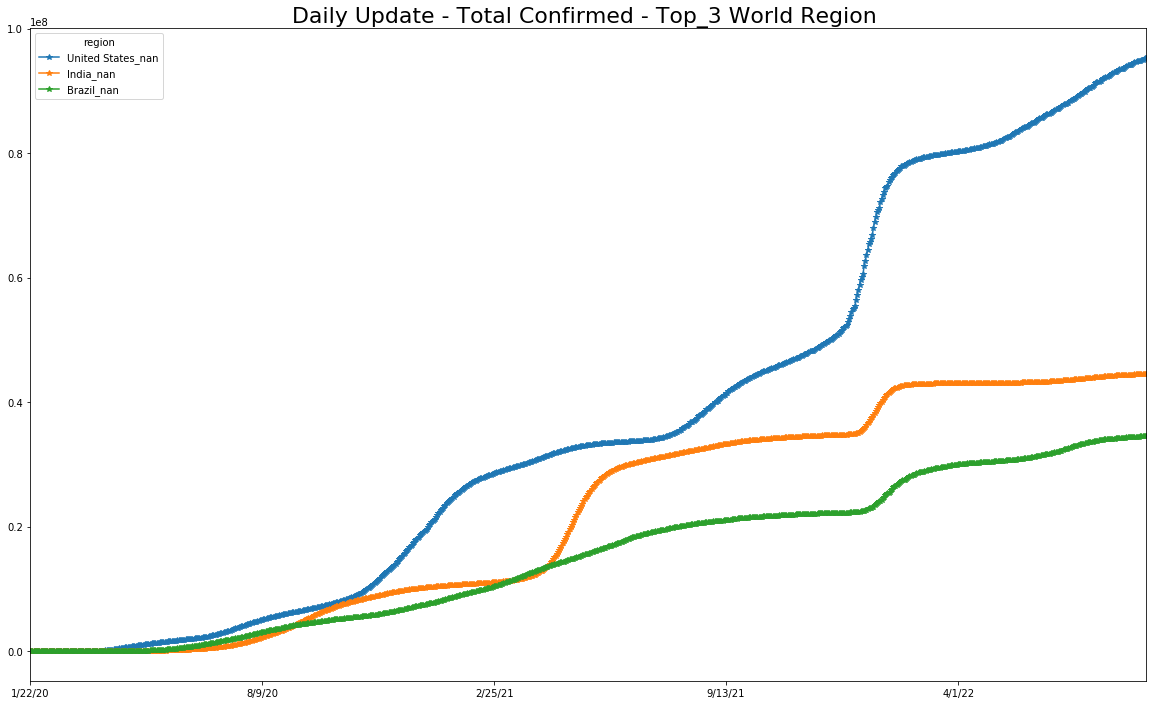

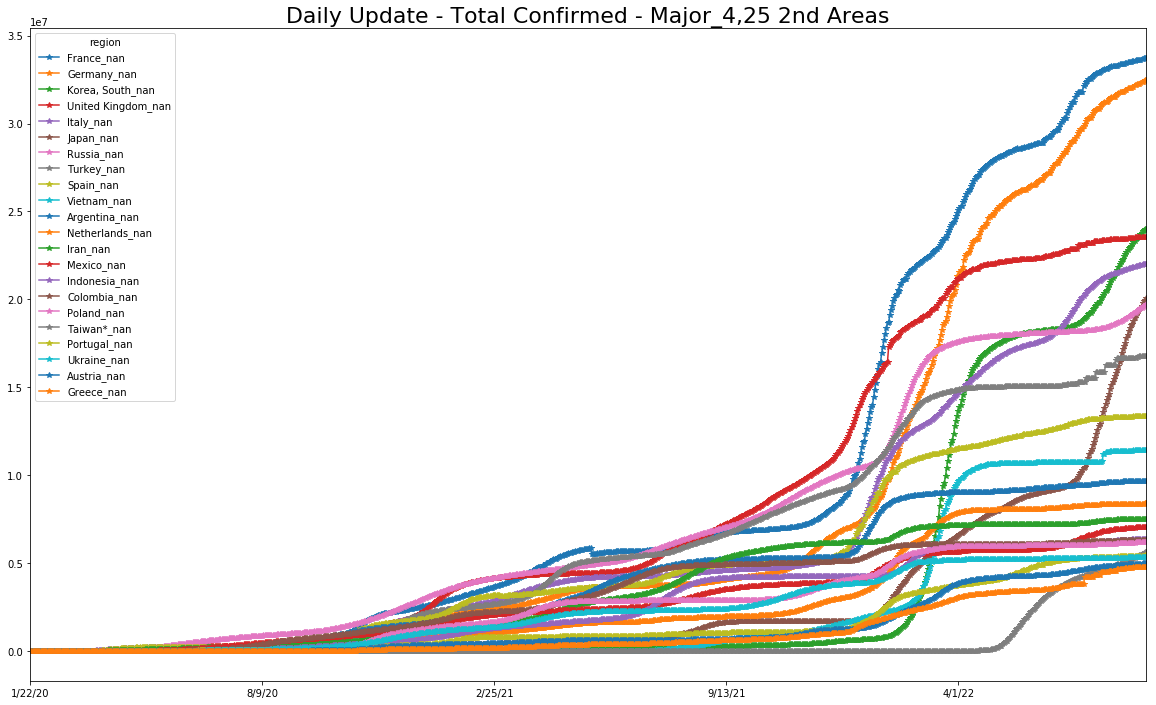

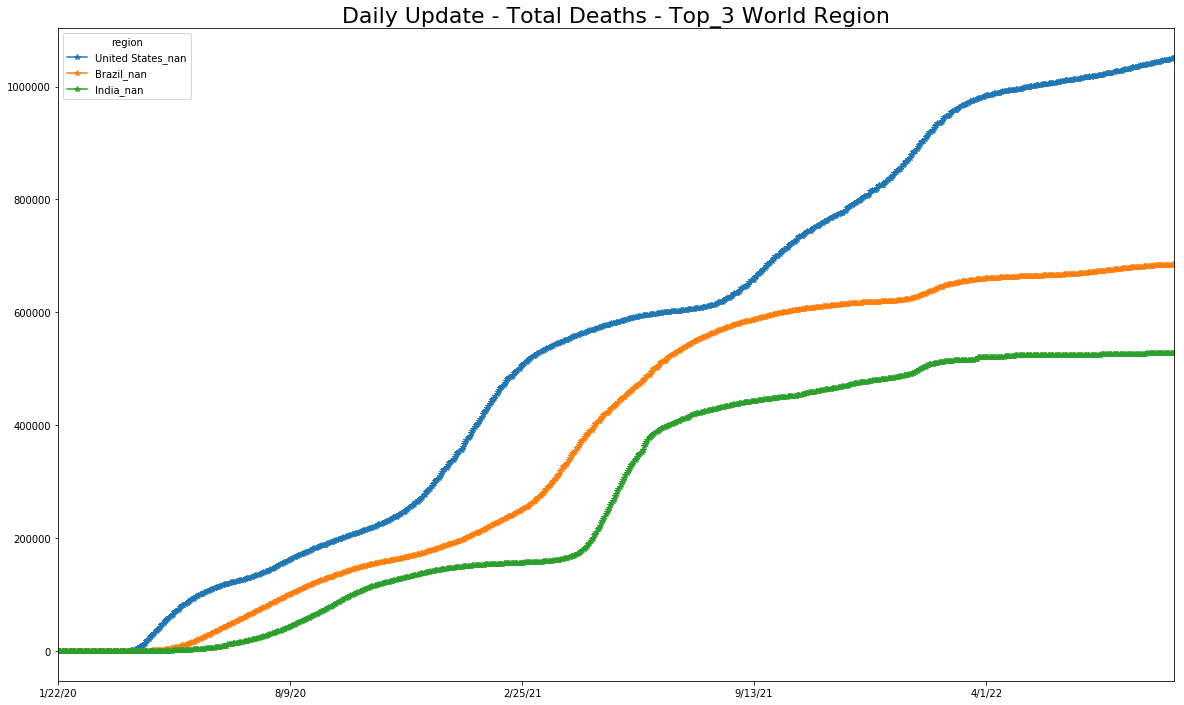

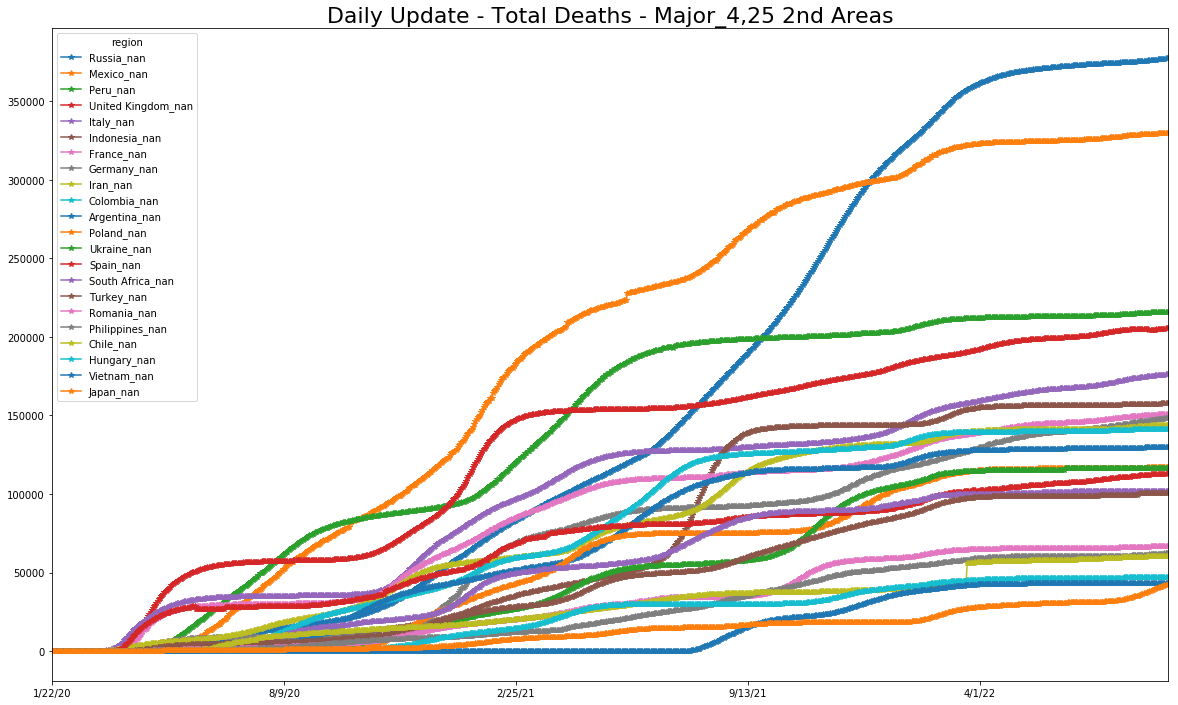

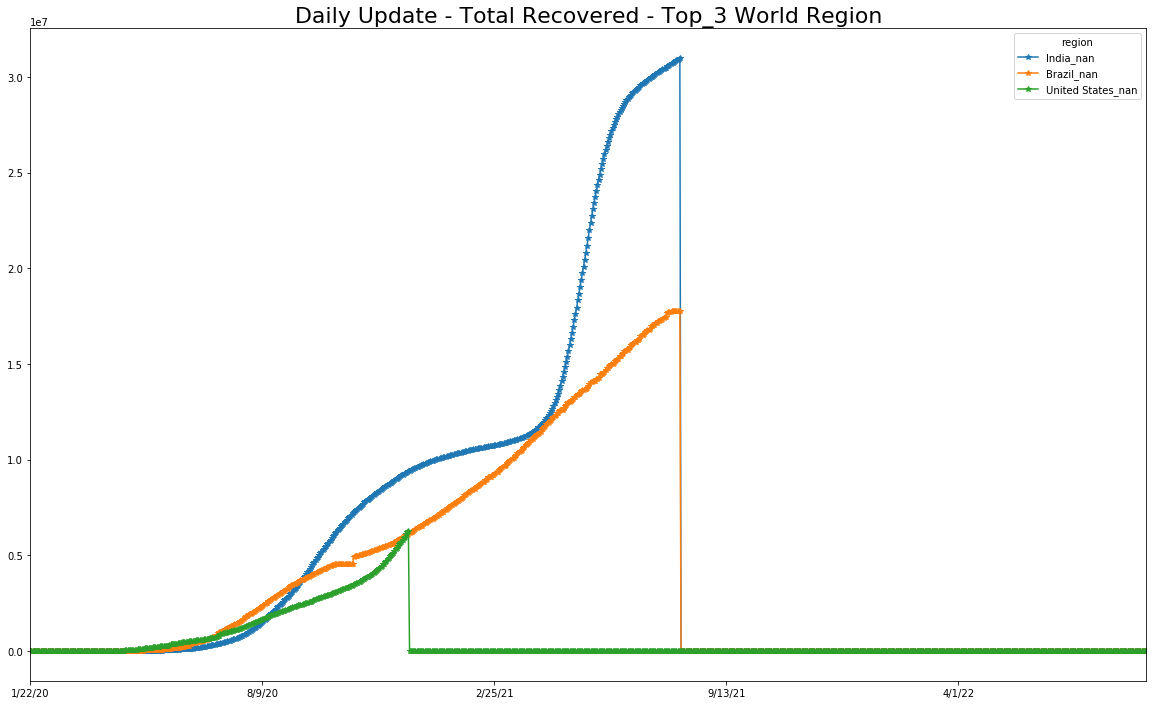

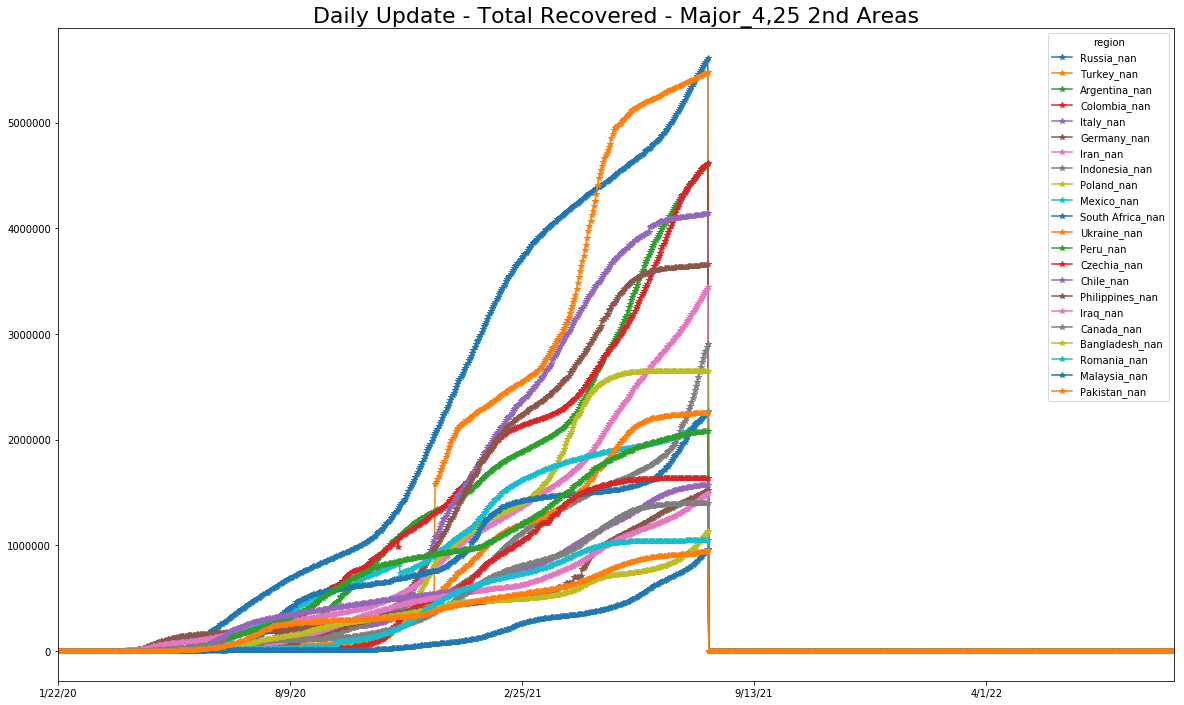

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/09/11


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/27/21           157190       199137       209980        16712       65139   
11/28/21           157218       199555       210152        16712       65144   
11/29/21           157260       199750       210344        16712       65155   

region    Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/27/21               0                     4141        5325560       337522   
11/28/21               0                     4141        5326448       337931   
11/29/21               0                     4141        5328416       338120   

region    Australia_Australian Capital Territory  ...  Uruguay_nan  \
11/27/21                                    2117  ...       399181   
11/28/21                                    2124  ...       399348   
11/29/21                                    2130  ...       399504   

region    Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
11/27/21          192599            6         430046      1197404   
11/28/21          192831            6         430696      1210340   
11/29/21          193065            6         431296      1224110   

region    West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
11/27/21                  459479                         0       9981   
11/28/21                  459479                         0       9987   
11/29/21                  460053                         0       9995   

region    Zambia_nan  Zimbabwe_nan  
11/27/21      210138        133836  
11/28/21      210143        133951  
11/29/21      210150        134226  

[3 rows x 285 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
9/7/22            195012       330516       270489        46113      102636   
9/8/22            195298       330687       270507        46113      102636   
9/9/22            195471       330842       270522        46113      103131   
9/10/22           195631       330948       270532        46113      103131   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
9/7/22               11                     8974        9689861       436727   
9/8/22               11                     8974        9689861       436727   
9/9/22               11                     8974        9689861       436727   
9/10/22              11                     8974        9689861       436727   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
9/7/22                                   203786  ...       981186   
9/8/22                                   203786  ...       981186   
9/9/22                                   203680  ...       981186   
9/10/22                                  203680  ...       981186   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
9/7/22           243893        11902         543204     11428632   
9/8/22           243893        11902         543204     11431823   
9/9/22           243893        11908         543204     11435472   
9/10/22          243893        11908         543759     11437970   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
9/7/22                   702591                       535      11931   
9/8/22                   702591                       535      11932   
9/9/22                   702591                       535      11932   
9/10/22                  702591                       535      11932   

region   Zambia_nan  Zimbabwe_nan  
9/7/22       333150        256825  
9/8/22       333180        256834  
9/9/22       333204        256859  
9/10/22      333220        256870  

[4 rows x 285 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-11-28  Afghanistan_nan     157218             0             0   
2     2021-11-29  Afghanistan_nan     157260            28             0   
3     2021-11-30  Afghanistan_nan     157289            42             0   
4     2021-12-01  Afghanistan_nan     157359            29            99   
5     2021-12-02  Afghanistan_nan     157387            70           141   
6     2021-12-03  Afghanistan_nan     157412            28           127   
7     2021-12-04  Afghanistan_nan     157431            25           123   
8     2021-12-05  Afghanistan_nan     157454            19            72   
9     2021-12-06  Afghanistan_nan     157499            23            67   
10    2021-12-07  Afghanistan_nan     157508            45            87   
11    2021-12-08  Afghanistan_nan     157542             9            77   
12    2021-12-09  Afghanistan_nan     157585            34            88   
13    2021-12-10  Afghanistan_nan     157603            43            86   
14    2021-12-11  Afghanistan_nan     157611            18            95   
15    2021-12-12  Afghanistan_nan     157633             8            69   
16    2021-12-13  Afghanistan_nan     157648            22            48   
17    2021-12-14  Afghanistan_nan     157660            15            45   
18    2021-12-15  Afghanistan_nan     157665            12            49   
19    2021-12-16  Afghanistan_nan     157725             5            32   
20    2021-12-17  Afghanistan_nan     157734            60            77   
21    2021-12-18  Afghanistan_nan     157745             9            74   
22    2021-12-19  Afghanistan_nan     157787            11            80   
23    2021-12-20  Afghanistan_nan     157797            42            62   
24    2021-12-21  Afghanistan_nan     157816            10            63   
25    2021-12-22  Afghanistan_nan     157841            19            71   
26    2021-12-23  Afghanistan_nan     157878            25            54   
27    2021-12-24  Afghanistan_nan     157887            37            81   
28    2021-12-25  Afghanistan_nan     157895             9            71   
29    2021-12-26  Afghanistan_nan     157951             8            54   
30    2021-12-27  Afghanistan_nan     157967            56            73   
...          ...              ...        ...           ...           ...   
84069 2022-08-13     Zimbabwe_nan     256522             9            32   
84070 2022-08-14     Zimbabwe_nan     256539             0            30   
84071 2022-08-15     Zimbabwe_nan     256544            17            26   
84072 2022-08-16     Zimbabwe_nan     256561             5            22   
84073 2022-08-17     Zimbabwe_nan     256565            17            39   
84074 2022-08-18     Zimbabwe_nan     256579             4            26   
84075 2022-08-19     Zimbabwe_nan     256596            14            35   
84076 2022-08-20     Zimbabwe_nan     256616            17            35   
84077 2022-08-21     Zimbabwe_nan     256624            20            51   
84078 2022-08-22     Zimbabwe_nan     256628             8            45   
84079 2022-08-23     Zimbabwe_nan     256628             4            32   
84080 2022-08-24     Zimbabwe_nan     256628             0            12   
84081 2022-08-25     Zimbabwe_nan     256675             0             4   
84082 2022-08-26     Zimbabwe_nan     256682            47            47   
84083 2022-08-27     Zimbabwe_nan     256682             7            54   
84084 2022-08-28     Zimbabwe_nan     256699             0            54   
84085 2022-08-29     Zimbabwe_nan     256704            17            24   
84086 2022-08-30     Zimbabwe_nan     256708             5            22   
84087 2022-08-31     Zimbabwe_nan     256726             4            26   
84088 2022-09-01     Zimbabwe_nan     256738            18            27   
84089 2022-09-02     Zimbabwe_nan     256744            12  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
84098 2022-09-11  Zimbabwe_nan          0            11            45   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
84098           115         100.004286         100.017526         100.044794   

       last_day  kalman_prediction  population  infected_rate  min  max  
84098    256870           256888.0    14862924       0.000173  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
84098 2022-09-11  Zimbabwe_nan          0            11            45   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
84098           115         100.004286         100.017526         100.044794   

       last_day  kalman_prediction  population  infected_rate  min  max  
84098    256870           256888.0    14862924       0.000173  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
82362  2022-09-09  Zimbabwe_nan     256859             9            65   
82363  2022-09-10  Zimbabwe_nan     256870            25            77   
82364  2022-09-11  Zimbabwe_nan          0            11            45   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
82362            96         100.003508         100.025318         100.037396   
82363           115         100.009738         100.029990         100.044796   
82364           115         100.004286         100.017526         100.044794   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
82362               256834  ...    14862924       0.000173  NaN  NaN   
82363               256859  ...    14862924       0.000173  NaN  NaN   
82364               256870  ...    14862924       0.000173  NaN  NaN   

       population_percentage : infected_rate confirmed  \
82362                                         0.017280   
82363                                         0.017282   
82364                                         0.017283   

       population_percentage : factor 9/10 infected_rate confirmed  \
82362                                           0.155522             
82363                                           0.155537             
82364                                           0.155544             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
82362                     9.0                           0.605534   
82363                    10.0                           0.672815   
82364                    18.0                           1.211067   

       delta : roling 7day AVG  \
82362                13.714286   
82363                16.428571   
82364                16.428571   

       delta : aprox 14-day case notification rate per 100k hab  
82362                                           1.291805         
82363                                           1.547475         
82364                                           1.547475         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse           mae
274  United States_nan  3.179484e+13  5.638691e+06  457693.84375


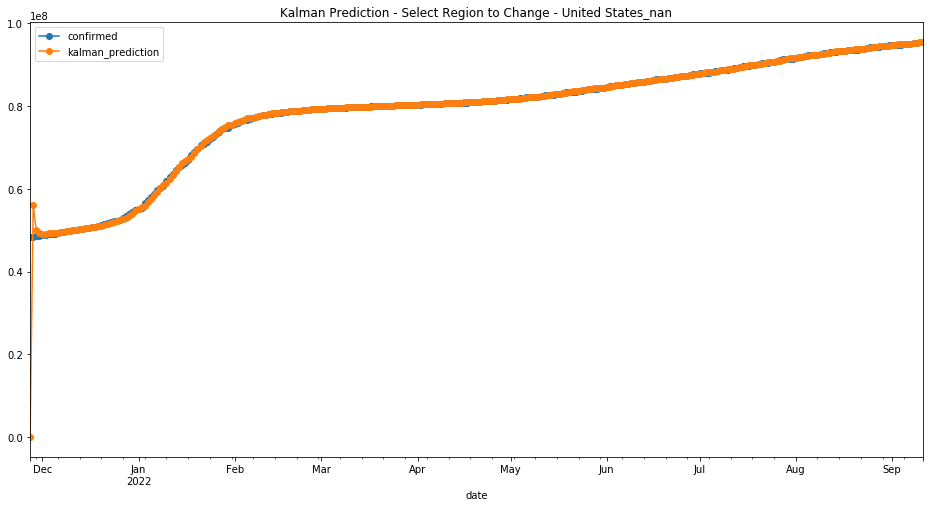

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse           mae
219  Russia_nan  1.364656e+12  1.168185e+06  86478.513889


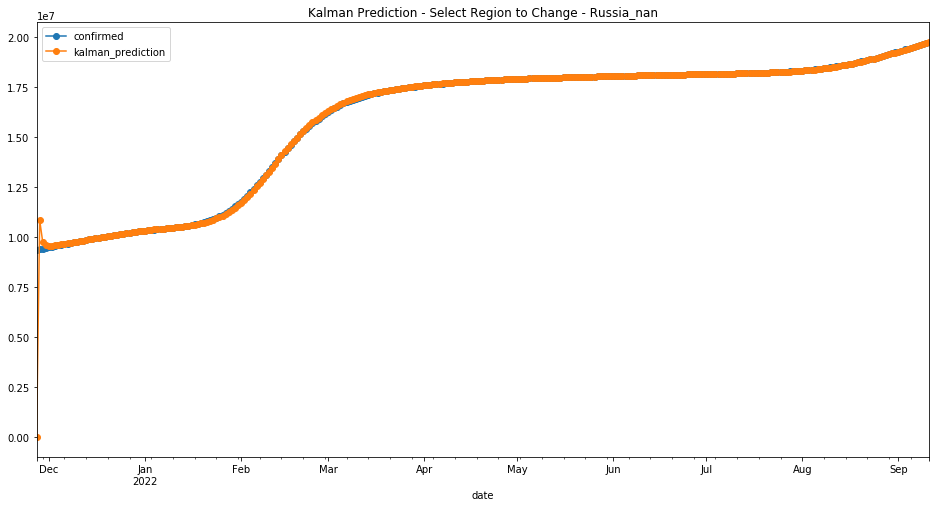

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse           mae
31  Brazil_nan  4.185282e+12  2.045796e+06  163389.46875


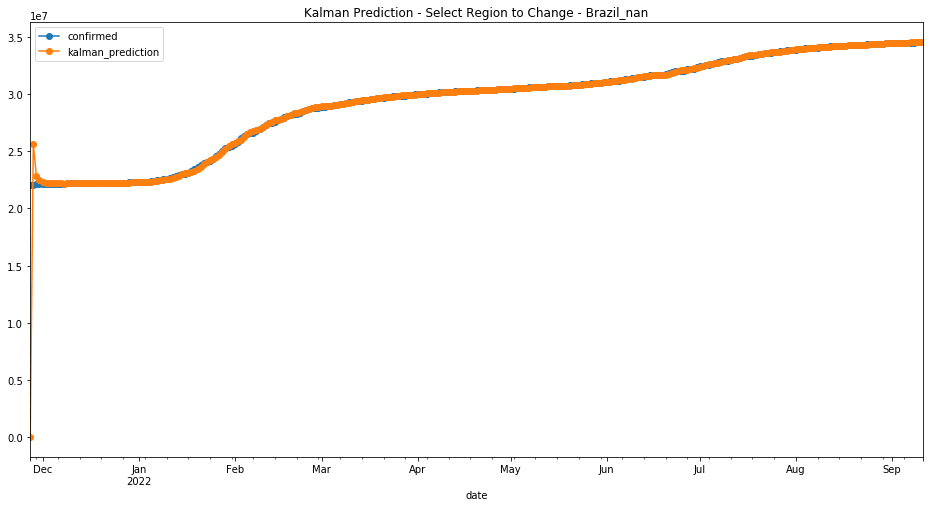

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse            mae
273  United Kingdom_nan  1.941171e+12  1.393259e+06  124086.677083


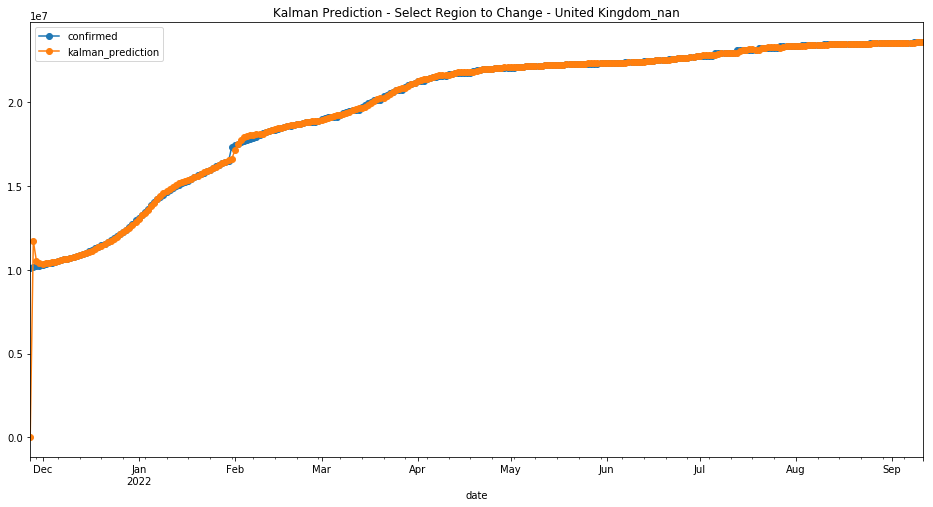

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpm0w_7gns
  JVM stdout: /tmp/tmpm0w_7gns/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpm0w_7gns/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 10 months and 15 days !!!
H2O cluster name:           H2O_from_python_unknownUser_ll0hya
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-09-03
last_train_date= 2022-09-10
first_bootstrap_date= 2022-09-02
boost_bootstrap_date= 2022-09-07
first_test_date= 2022-09-01
last_test_date= 2022-09-11
first_valid_date= 2022-09-09


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   195641.0     193520 2022-09-02  Afghanistan_nan
1   195756.0     193912 2022-09-03  Afghanistan_nan
2   195954.0     194163 2022-09-04  Afghanistan_nan
3   196238.0     194355 2022-09-05  Afghanistan_nan
4   196486.0     194614 2022-09-06  Afghanistan_nan
5   196708.0     195012 2022-09-07  Afghanistan_nan
6   197039.0     195298 2022-09-08  Afghanistan_nan
7   197382.0     195471 2022-09-09  Afghanistan_nan
8   197623.0     195631 2022-09-10  Afghanistan_nan
9   197814.0          0 2022-09-11  Afghanistan_nan
10  331160.0     329862 2022-09-02      Albania_nan
11  331417.0     330062 2022-09-03      Albania_nan
12  331629.0     330193 2022-09-04      Albania_nan
13  331766.0     330221 2022-09-05      Albania_nan
14  331790.0     330283 2022-09-06      Albania_nan
15  331838.0     330516 2022-09-07      Albania_nan
16  332004.0     330687 2022-09-08      Albania_nan
17  332141.0     330842 2022-09-09      Albania_nan
18  332294.0     330948 2022-09-10      Albania_nan
19  332409.0          0 2022-09-11      Albania_nan
20  272364.0     270405 2022-09-02      Algeria_nan
21  272408.0     270426 2022-09-03      Algeria_nan
22  272437.0     270443 2022-09-04      Algeria_nan
23  272458.0     270461 2022-09-05      Algeria_nan
24  272475.0     270476 2022-09-06      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  4981964.0    4984809 2022-09-07     Austria_nan
176  4987221.0    4984809 2022-09-08     Austria_nan
177  4986610.0    4984809 2022-09-09     Austria_nan
178  4986962.0    4984809 2022-09-10     Austria_nan
179  4986245.0          0 2022-09-11     Austria_nan
180   815908.0     814435 2022-09-02  Azerbaijan_nan
181   816345.0     815047 2022-09-03  Azerbaijan_nan
182   816989.0     815523 2022-09-04  Azerbaijan_nan
183   817451.0     815523 2022-09-05  Azerbaijan_nan
184   817414.0     816087 2022-09-06  Azerbaijan_nan
185   818059.0     816589 2022-09-07  Azerbaijan_nan
186   818471.0     816985 2022-09-08  Azerbaijan_nan
187   818836.0     817322 2022-09-09  Azerbaijan_nan
188   819171.0     817596 2022-09-10  Azerbaijan_nan
189   819454.0          0 2022-09-11  Azerbaijan_nan
190    38588.0      37081 2022-09-02     Bahamas_nan
191    38611.0      37081 2022-09-03     Bahamas_nan
192    38607.0      37081 2022-09-04     Bahamas_nan
193    38604.0      37101 2022-09-05     Bahamas_nan
194    38552.0      37101 2022-09-06     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220  101277.0     101215 2022-09-02  Barbados_nan
221  101379.0     101397 2022-09-03  Barbados_nan
222  101342.0     101451 2022-09-04  Barbados_nan
223  101518.0     101510 2022-09-05  Barbados_nan
224  101578.0     101624 2022-09-06  Barbados_nan
225  101616.0     101696 2022-09-07  Barbados_nan
226  101731.0     101747 2022-09-08  Barbados_nan
227  101807.0     101809 2022-09-09  Barbados_nan
228  101845.0     101850 2022-09-10  Barbados_nan
229  101906.0          0 2022-09-11  Barbados_nan
230  995365.0     994037 2022-09-02   Belarus_nan
231  995365.0     994037 2022-09-03   Belarus_nan
232  995365.0     994037 2022-09-04   Belarus_nan
233  995365.0     994037 2022-09-05   Belarus_nan
234  995365.0     994037 2022-09-06   Belarus_nan
235  995365.0     994037 2022-09-07   Belarus_nan
236  995365.0     994037 2022-09-08   Belarus_nan
237  995365.0     994037 2022-09-09   Belarus_nan
238  995365.0     994037 2022-09-10   Belarus_nan
239  995365.0          0 2022-09-11   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  218016762316.3525
# MSE on the validation data =  157910211799476.38
# R^2 on the training data =  0.9990809069805915
# R^2 on the validation data =  0.3690566805793689


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1662883907006_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 218016762316.3525
RMSE: 466922.65132070053
MAE: 34228.89012365571
RMSLE: 0.4145440264098788
Mean Residual Deviance: 218016762316.3525

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 157910211799476.38
RMSE: 12566232.999569776
MAE: 4148544.834072127
RMSLE: 8.753052597473008
Mean Residual Deviance: 157910211799476.38
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-09-11 08:11:58  0.072 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-09-11 08:11:59  0.557 sec   1.0                410332.96117345267  80543.27083245061   168373139025.37424   12577478.330879465  4169133.058277027   158192961163742.47
     2022-09-11 08:11:59  0.721 sec   2.0                659116.4285740203   98466.80437729869   434434466416.17163   12517013.655392975  4150792.7013830235  156675630849294.22
     2022-09-11 08:11:59  0.855 sec   3.0                475650.6555387859   82319.6733893609    226243546114.47678   12579165.950950209  4172132.5142024956  158235416021545.1
     2022-09-11 08:11:59  1.231 sec   4.0                690052.9834334401   81001.7422976141    476173119945.39154   12588195.785745414  4167178.3349586003  158462673140258.6
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-09-11 08:12:22  24.099 sec  271.0              469083.02691113355  36976.39300235241   220038886136.11124   12568554.454023201  4147845.3462344836  157968561063746.44
     2022-09-11 08:12:26  28.125 sec  330.0              462659.40444819676  35869.234767190996  214053724524.3601    12560705.020330975  4147603.091120554   157771310607767.75
     2022-09-11 08:12:30  32.150 sec  388.0              461602.803147221    34936.066471023085  213077147873.37207   12564377.485764613  4147862.336259087   157863581604788.72
     2022-09-11 08:12:35  36.866 sec  457.0              467850.89742191473  34524.02679548851   218884462218.49097   12566078.429675486  4148284.043785508   157906327100755.53
     2022-09-11 08:12:39  40.530 sec  500.0              466922.65132070053  34228.89012365571   218016762316.3525    12566232.999569776  4148544.834072127   157910211799476.38


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  4.15016e+20            1                    0.380461
last_day           3.08653e+20            0.743713             0.282954
region             2.45459e+20            0.591446             0.225022
7_day_change       4.68471e+19            0.11288              0.0429466
3_day_change       2.66929e+19            0.0643178            0.0244704
infected_rate      2.03909e+19            0.0491329            0.0186932
1_day_change       1.23328e+19            0.0297166            0.011306
7_day_change_rate  7.70551e+18            0.0185668            0.00706395
3_day_change_rate  5.85757e+18            0.0141141            0.00536987
1_day_change_rate  1.86729e+18            0.00449933           0.00171182

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         4.150158e+20           1.000000    0.380461
1           last_day         3.086528e+20           0.743713    0.282954
2             region         2.454594e+20           0.591446    0.225022
3       7_day_change         4.684714e+19           0.112880    0.042947
4       3_day_change         2.669289e+19           0.064318    0.024470
5      infected_rate         2.039094e+19           0.049133    0.018693
6       1_day_change         1.233284e+19           0.029717    0.011306
7  7_day_change_rate         7.705511e+18           0.018567    0.007064
8  3_day_change_rate         5.857572e+18           0.014114    0.005370
9  1_day_change_rate         1.867292e+18           0.004499    0.001712

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


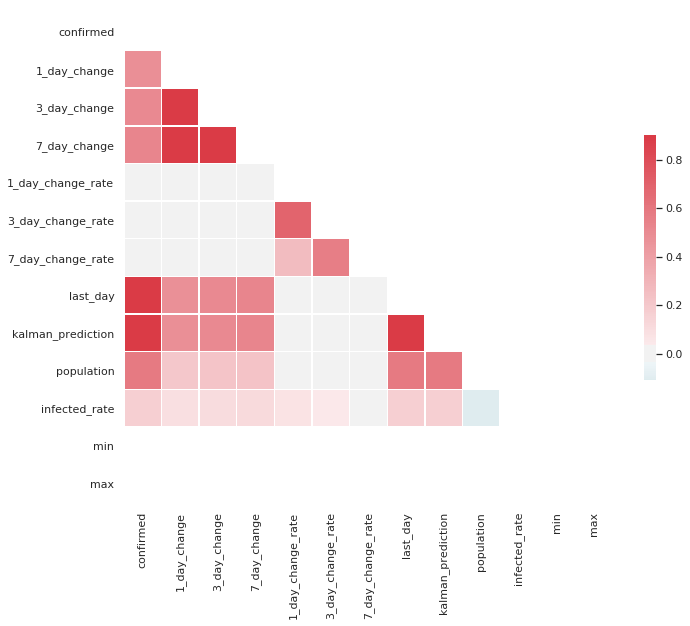

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.481517
3_day_change         0.512507
7_day_change         0.530070
1_day_change_rate    0.017456
3_day_change_rate    0.006988
7_day_change_rate   -0.003478
last_day             0.995847
kalman_prediction    0.996542
population           0.587454
infected_rate        0.170853
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


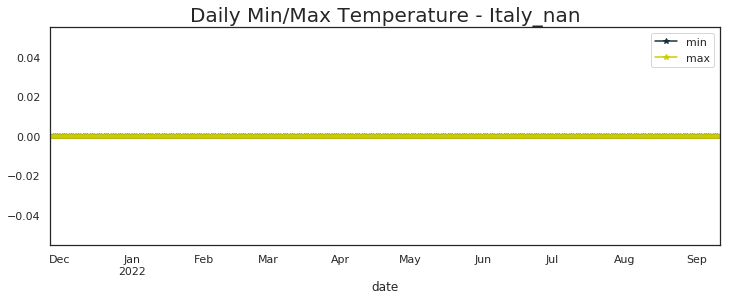

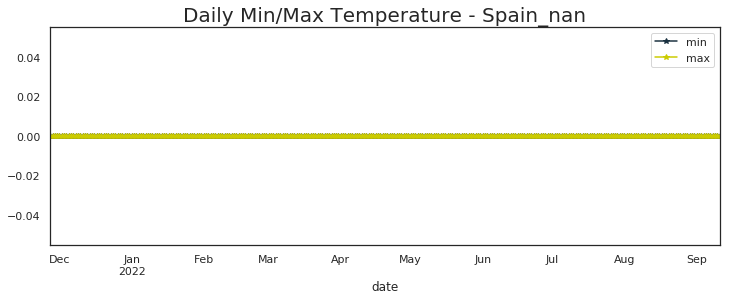

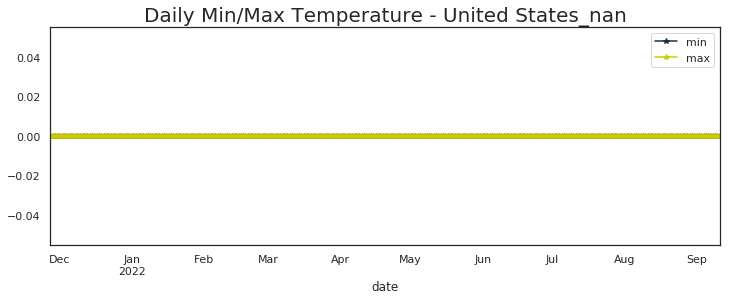

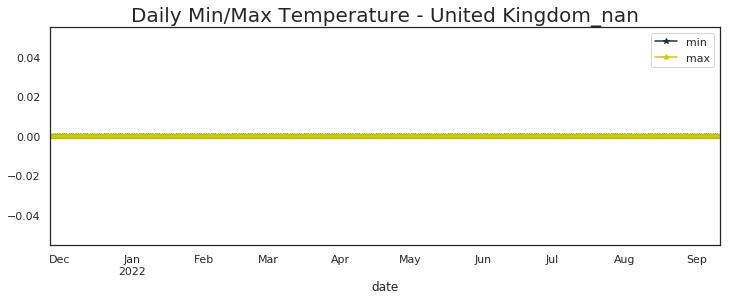

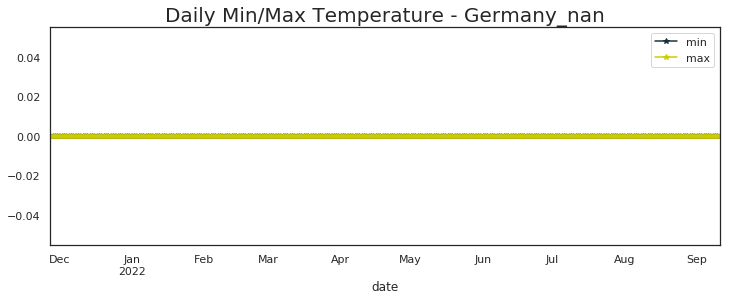

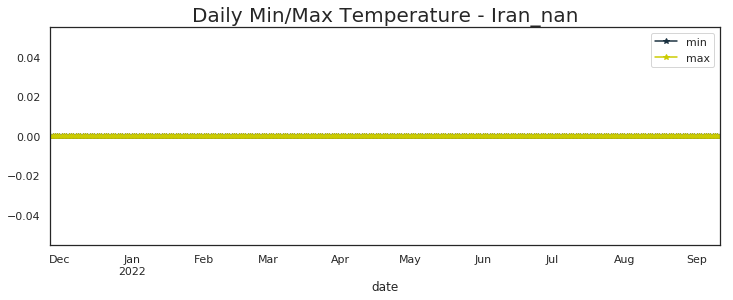

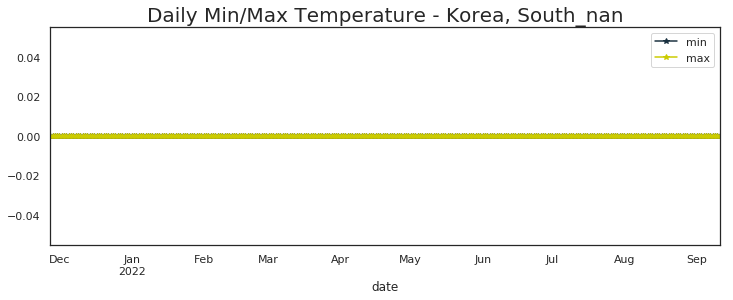

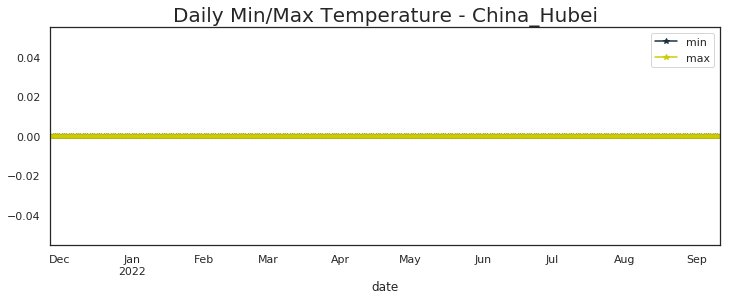

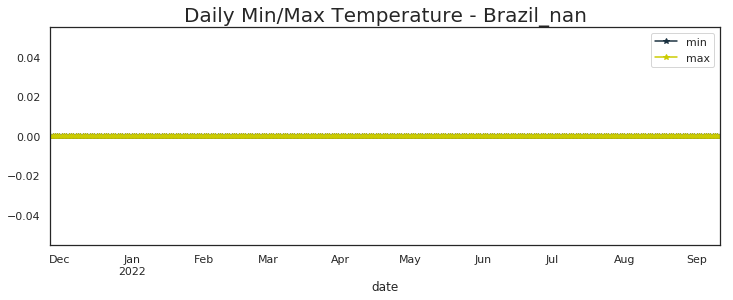

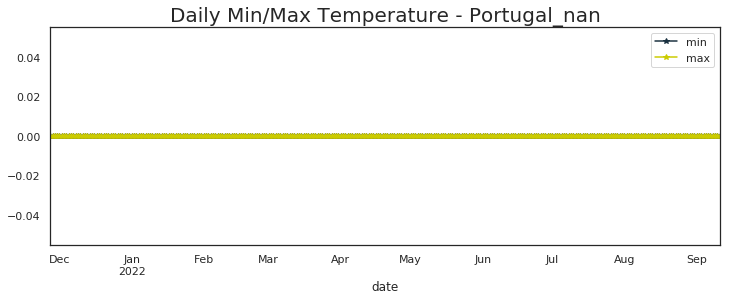

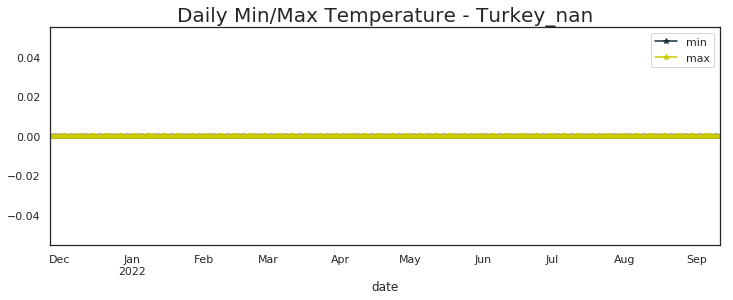

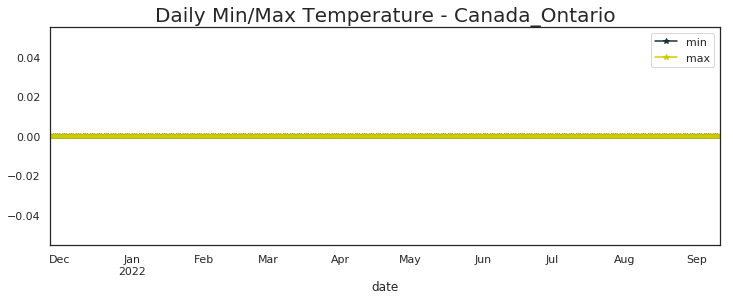

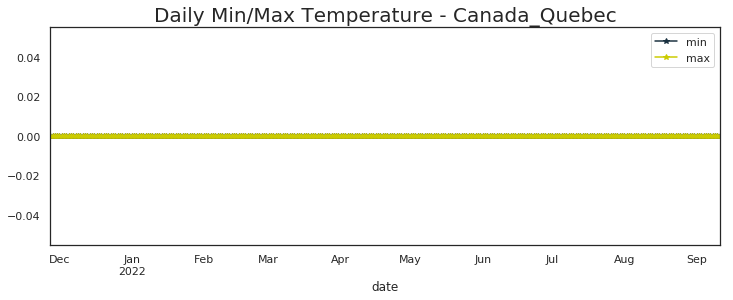

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                           min  max
region                             
United States_nan          0.0  0.0
India_nan                  0.0  0.0
Brazil_nan                 0.0  0.0
France_nan                 0.0  0.0
Germany_nan                0.0  0.0
Korea, South_nan           0.0  0.0
United Kingdom_nan         0.0  0.0
Italy_nan                  0.0  0.0
Japan_nan                  0.0  0.0
Russia_nan                 0.0  0.0
Turkey_nan                 0.0  0.0
Spain_nan                  0.0  0.0
Vietnam_nan                0.0  0.0
Argentina_nan              0.0  0.0
Netherlands_nan            0.0  0.0
Iran_nan                   0.0  0.0
Mexico_nan                 0.0  0.0
Indonesia_nan              0.0  0.0
Colombia_nan               0.0  0.0
Poland_nan                 0.0  0.0
Taiwan*_nan                0.0  0.0
Portugal_nan               0.0  0.0
Ukraine_nan                0.0  0.0
Austria_nan                0.0  0.0
Greece_nan                 0

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

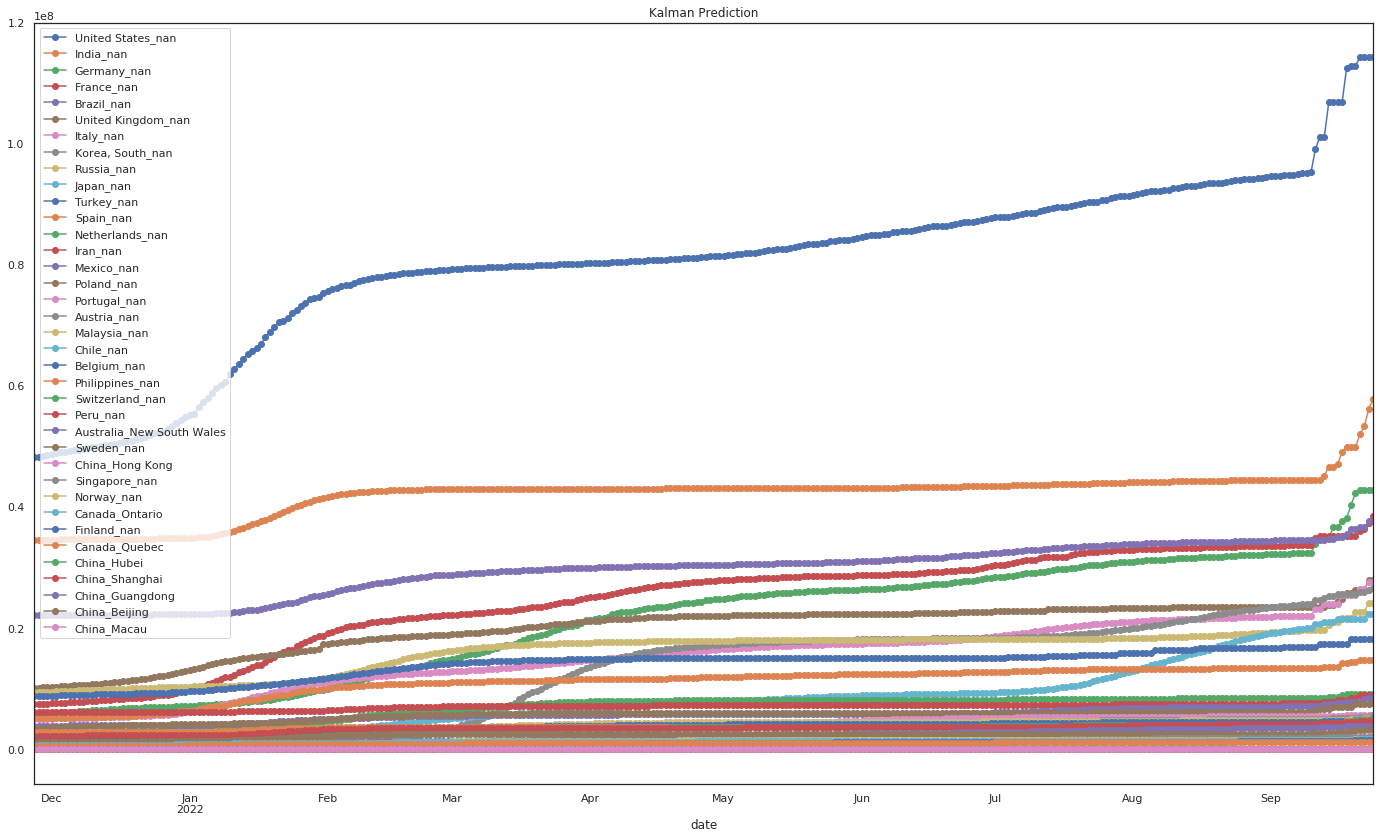

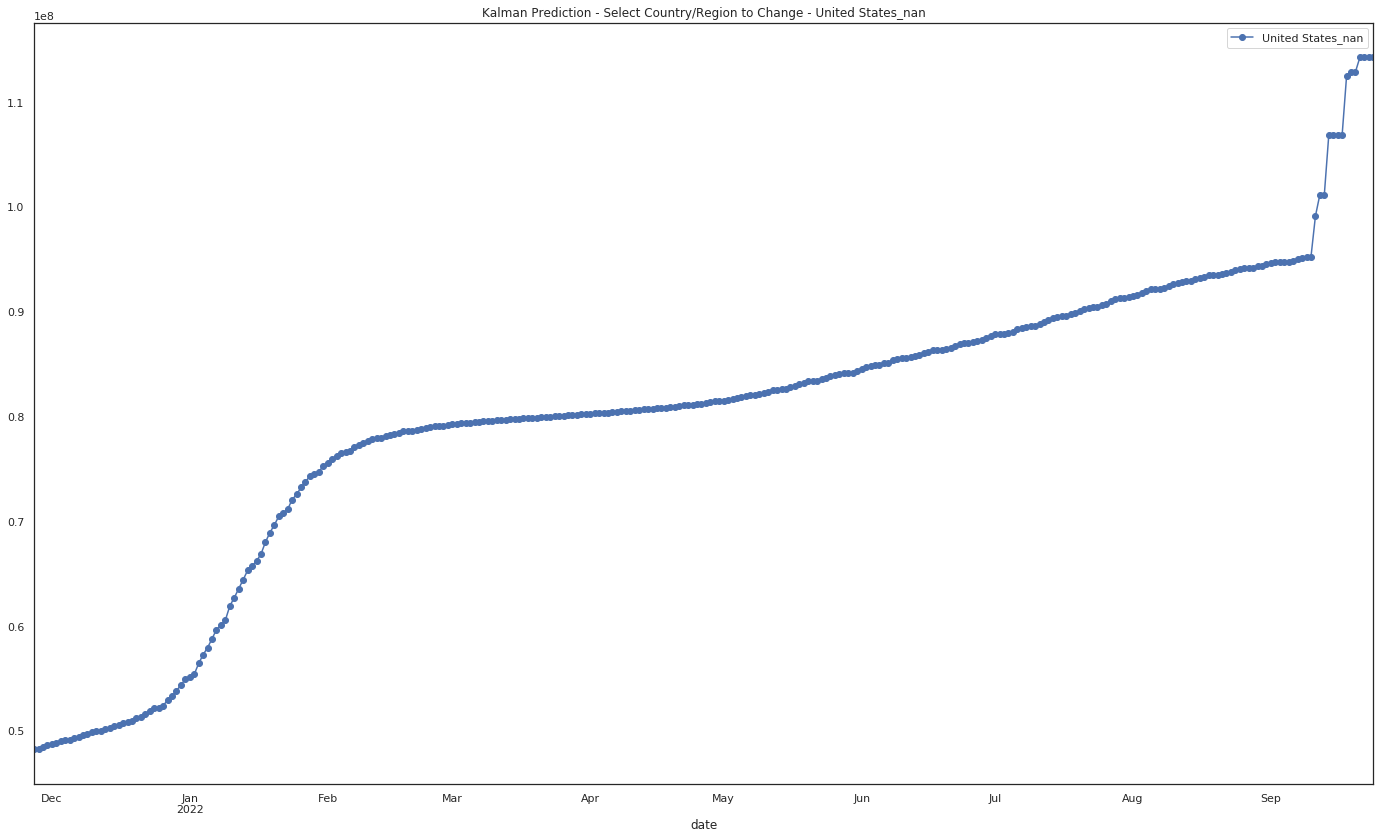

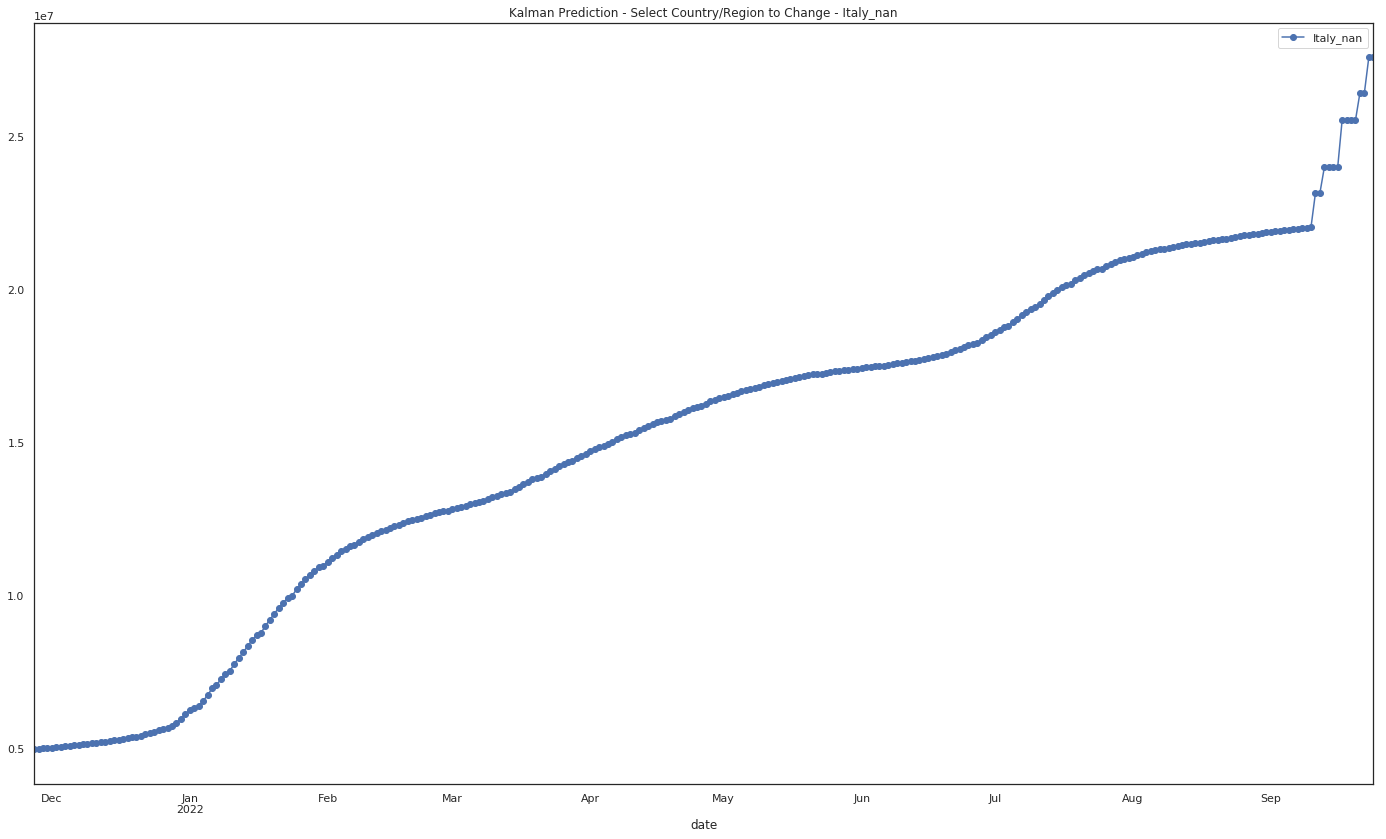

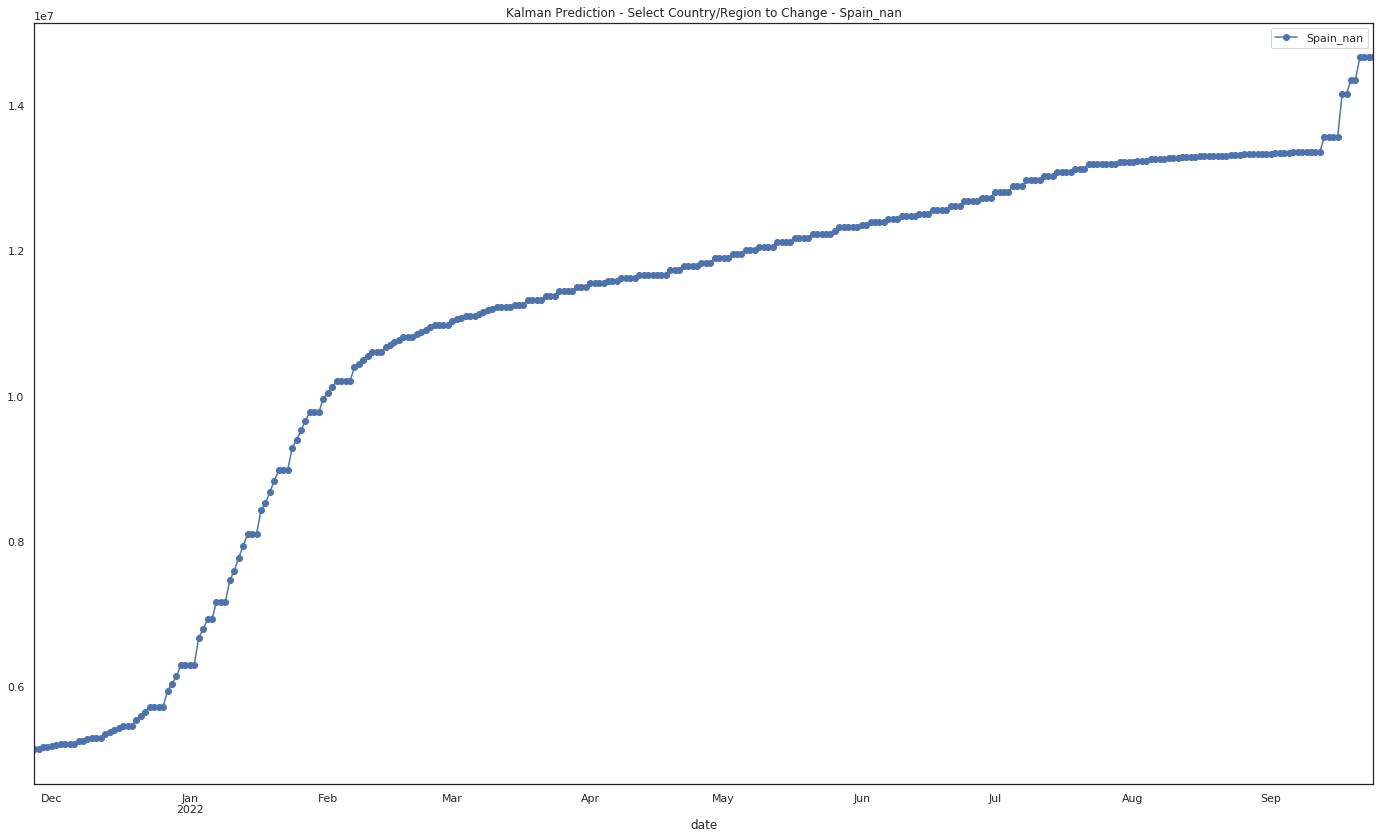

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


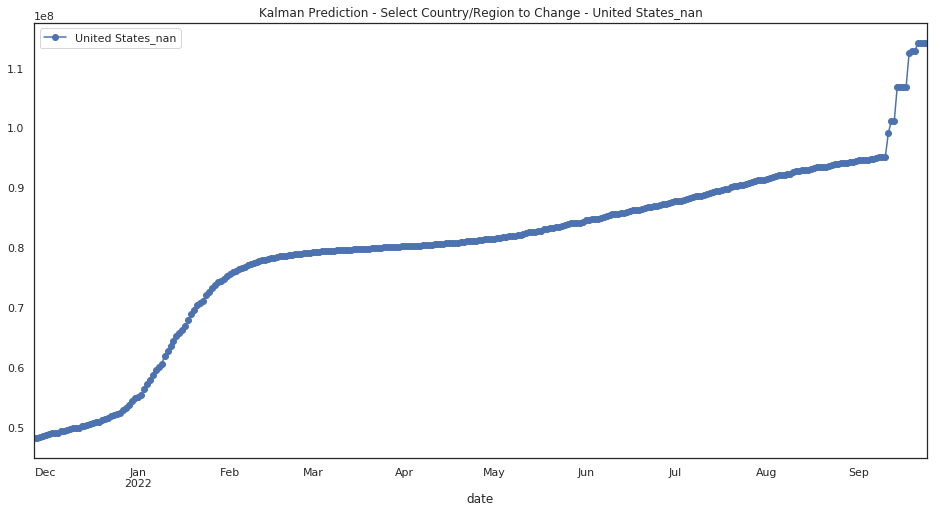

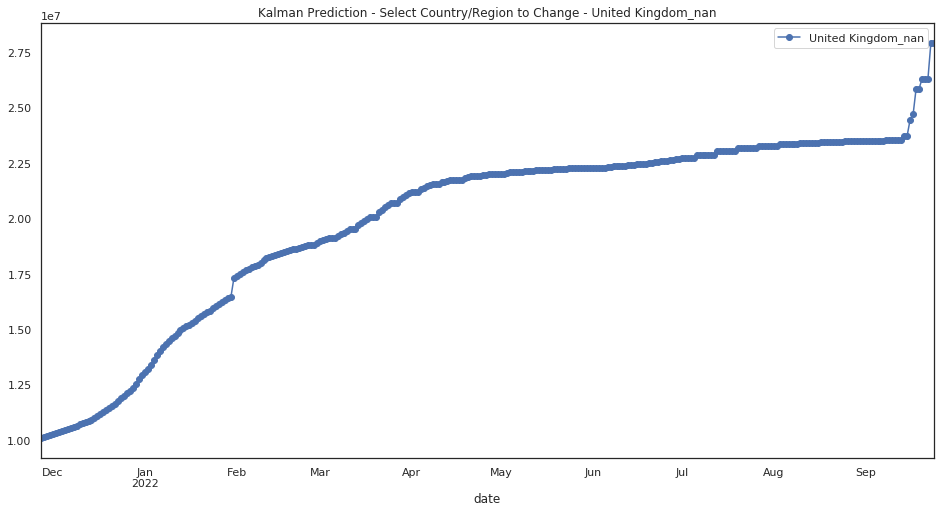

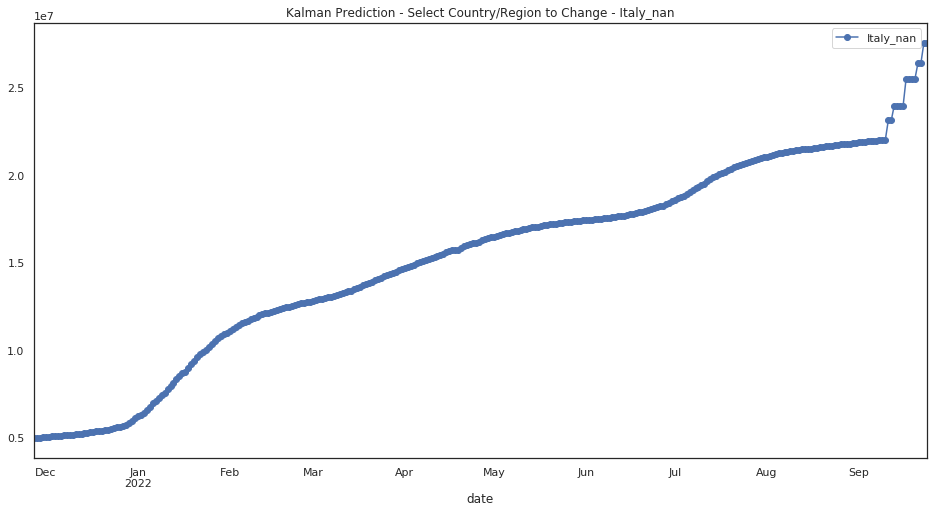

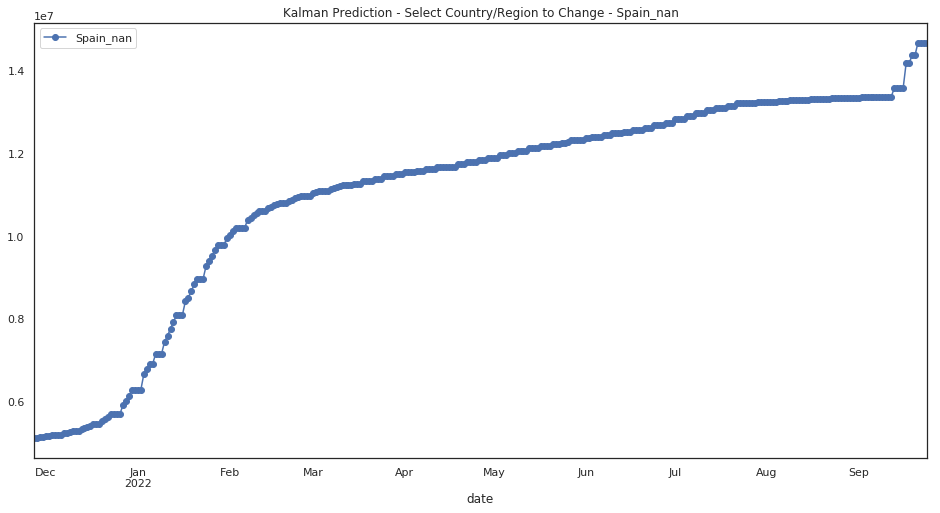

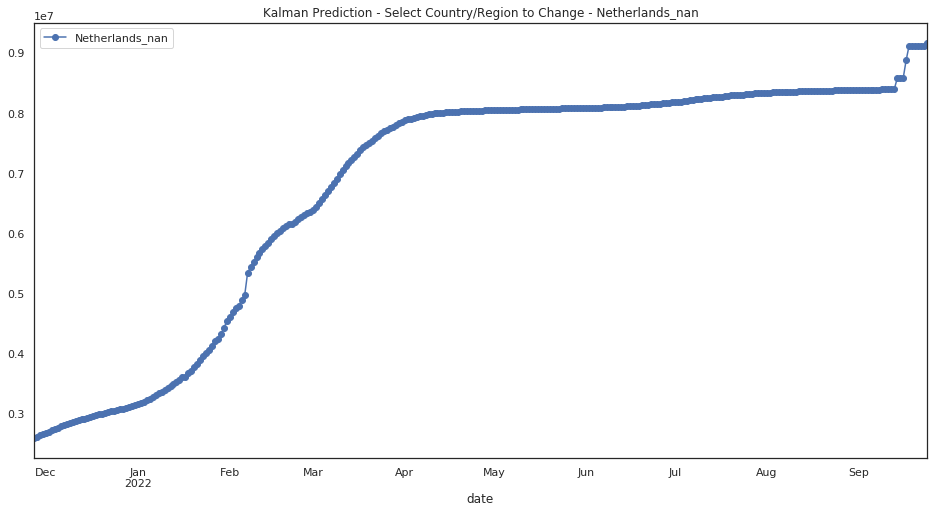

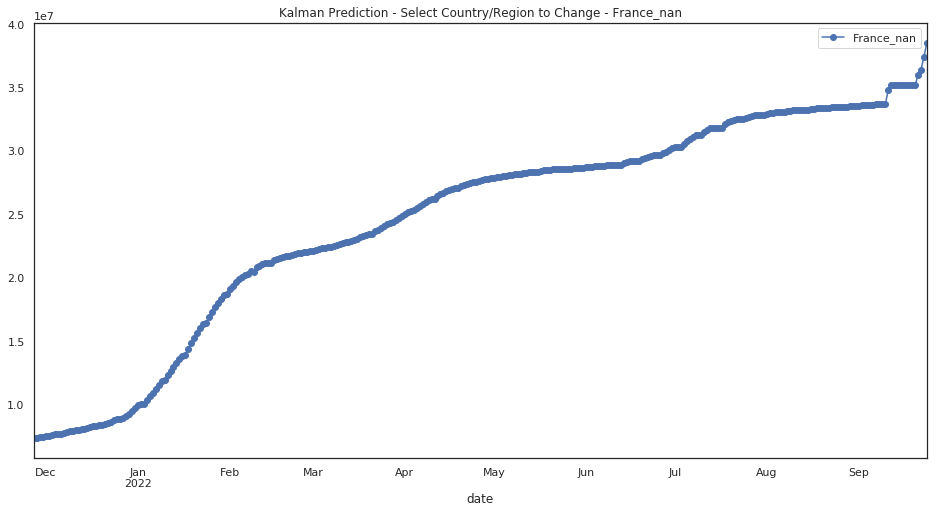

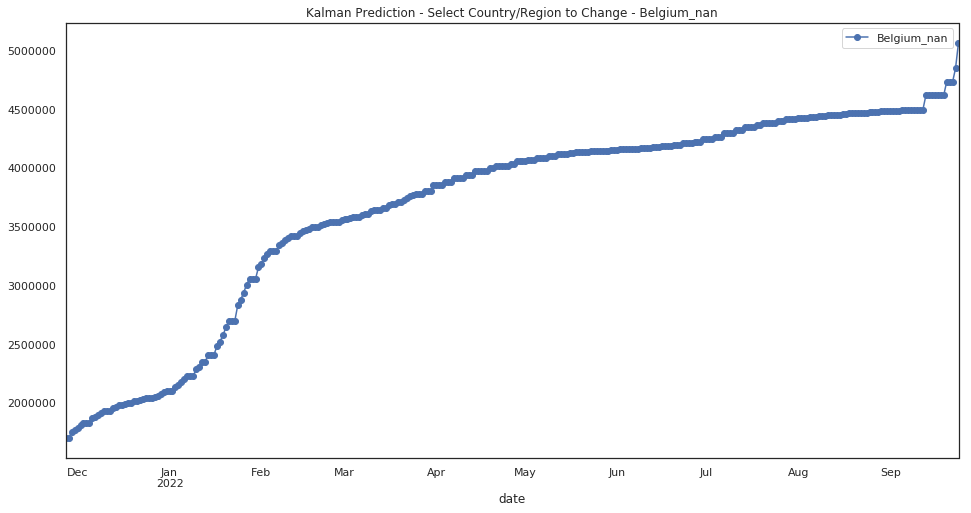

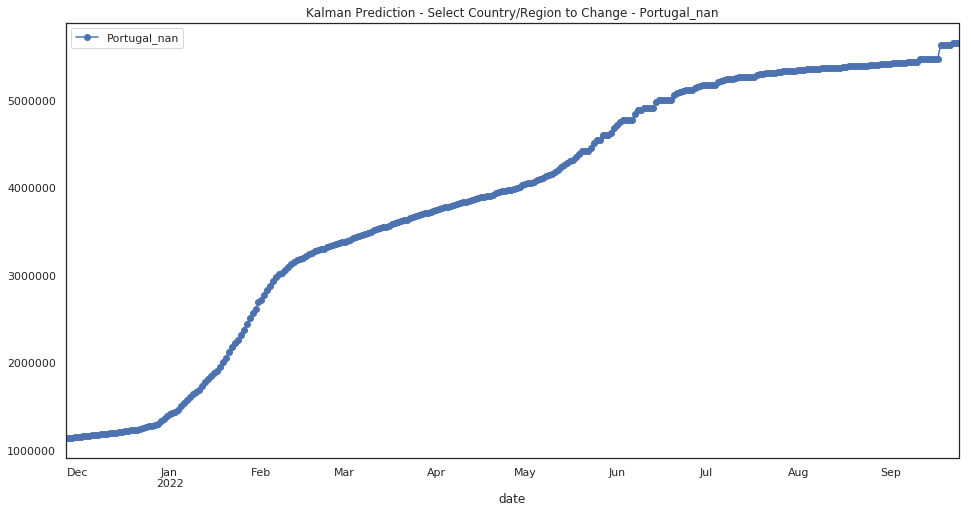

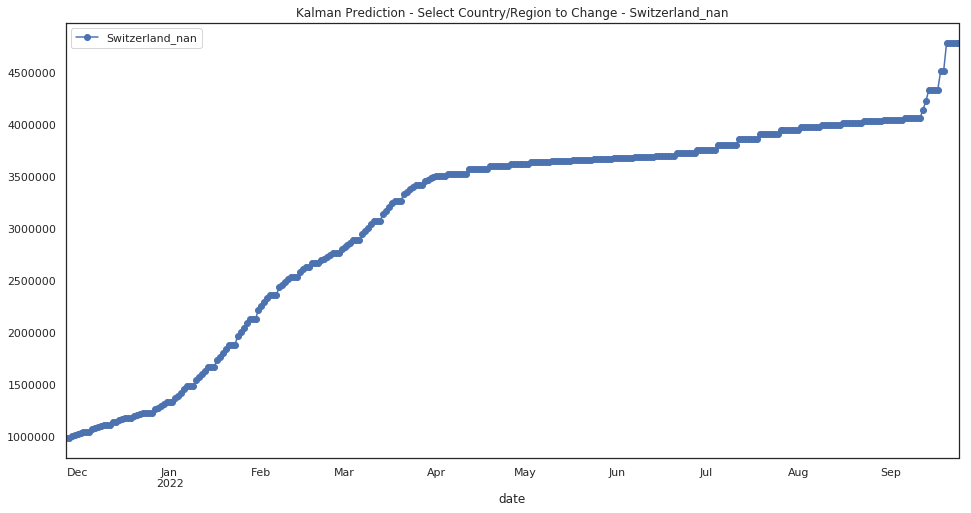

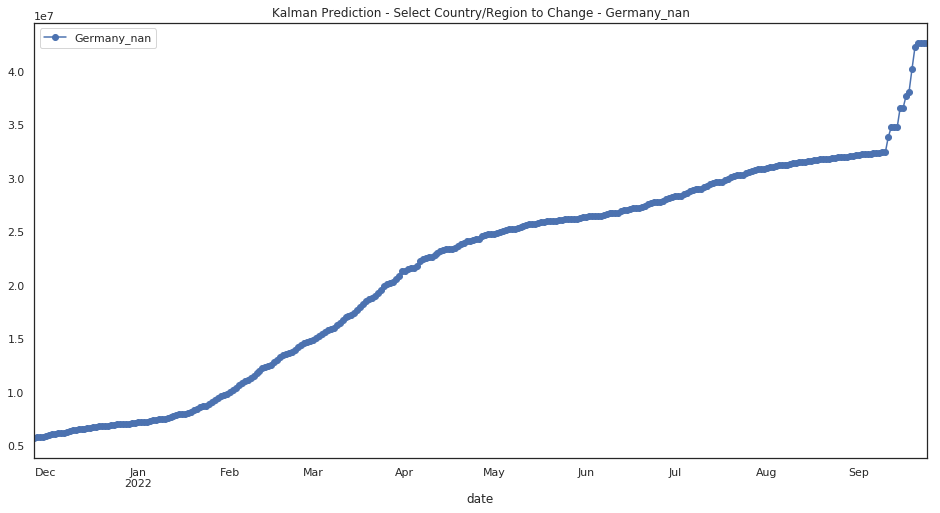

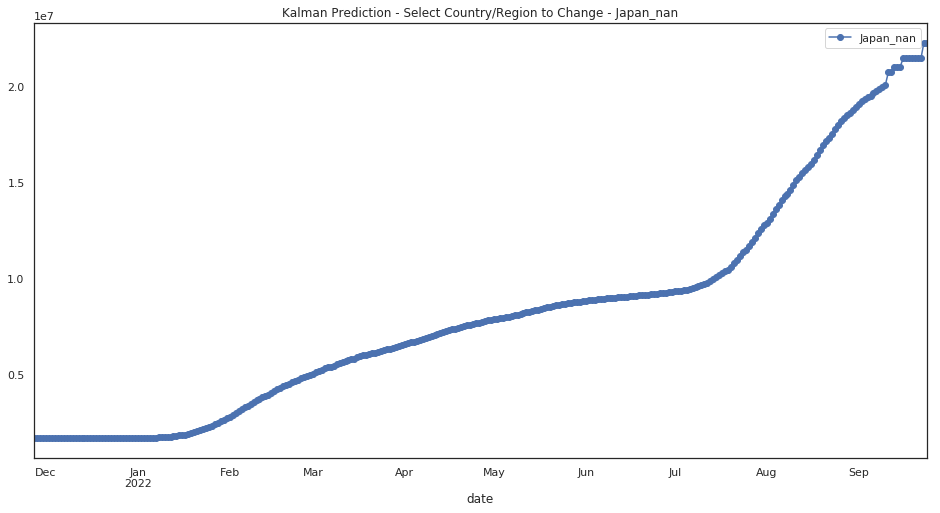

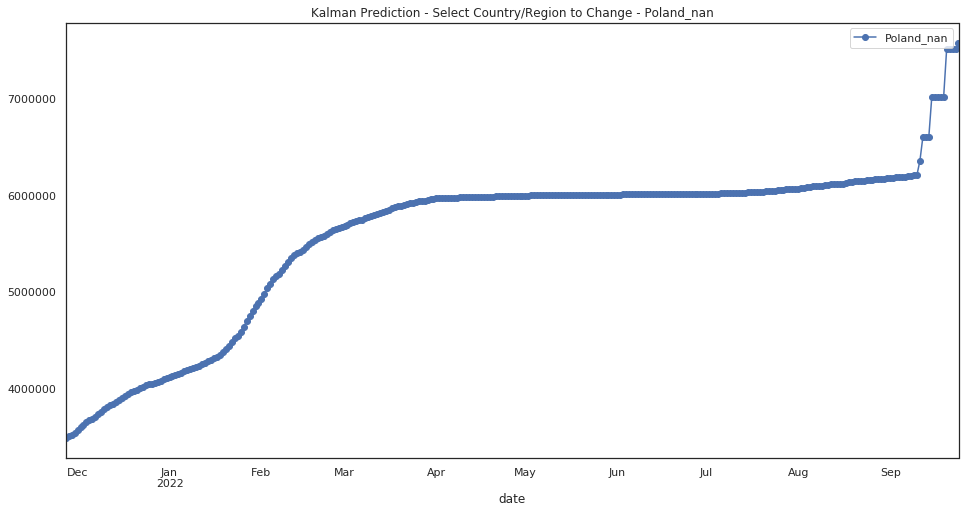

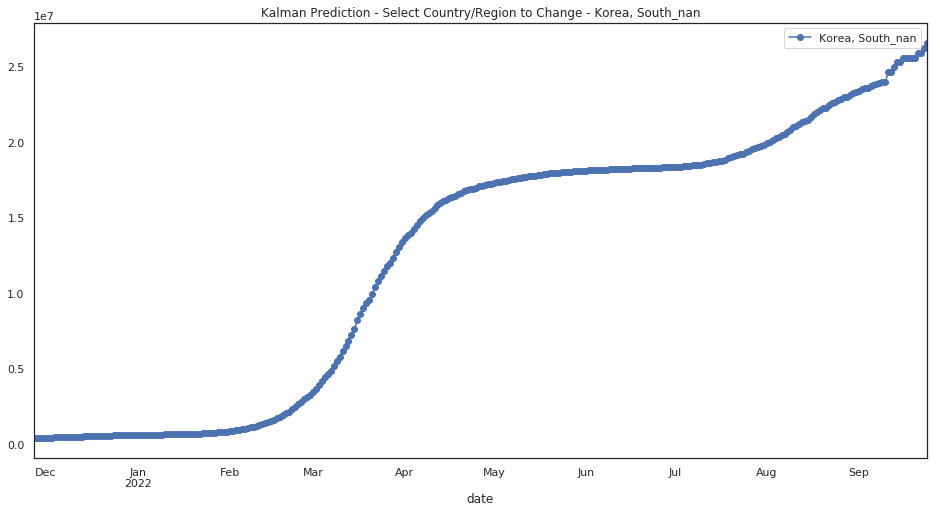

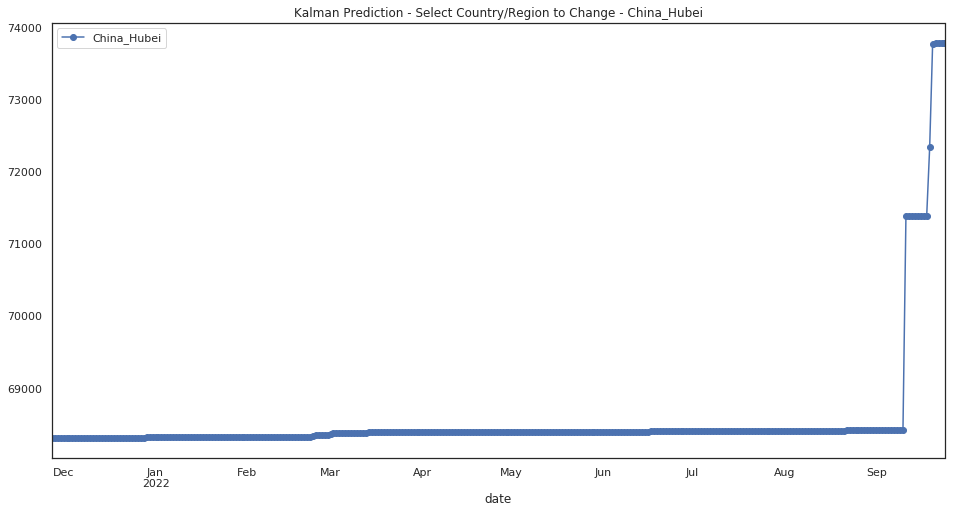

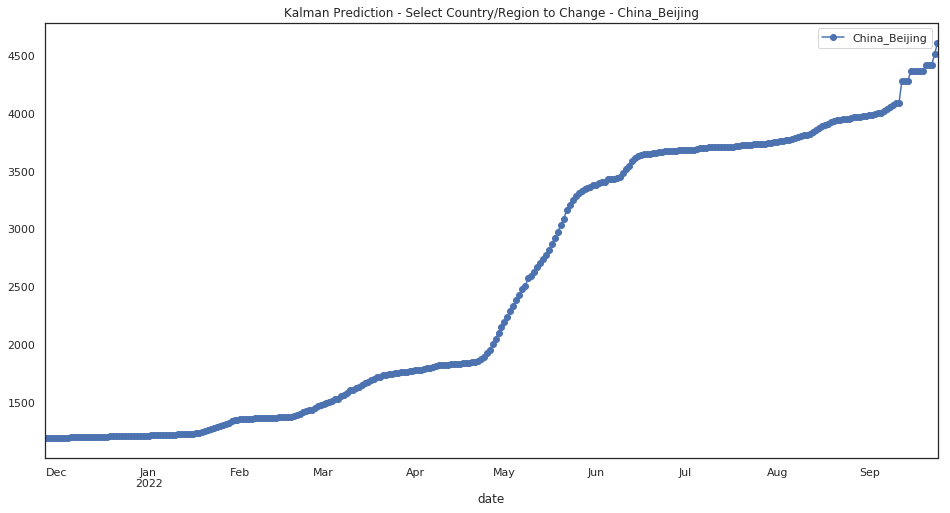

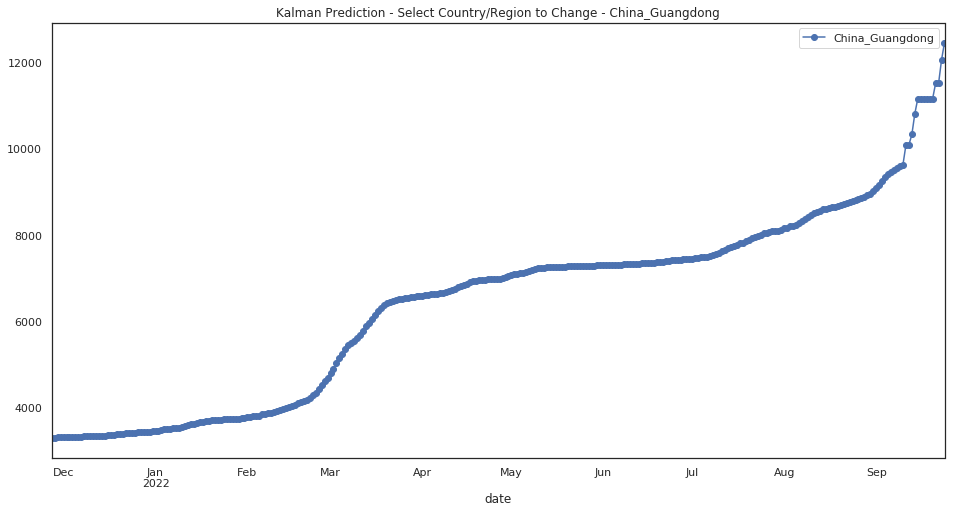

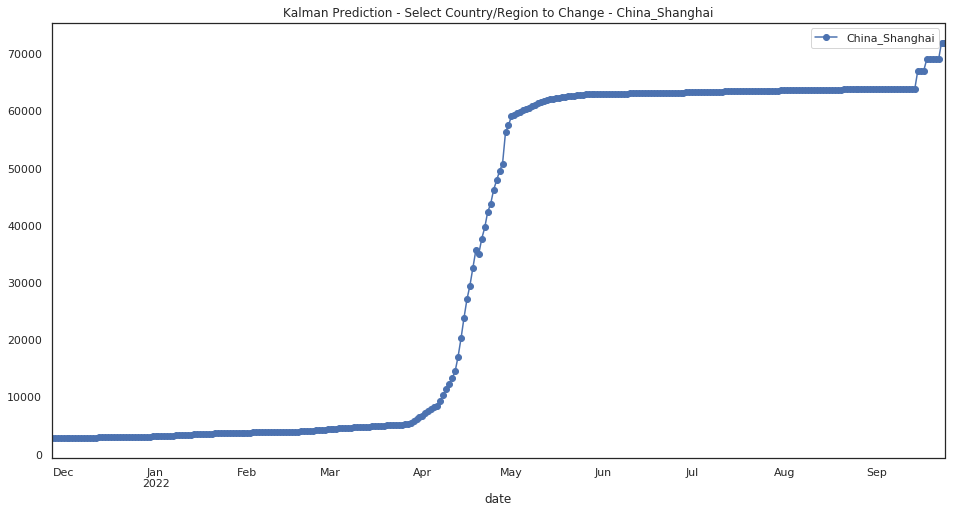

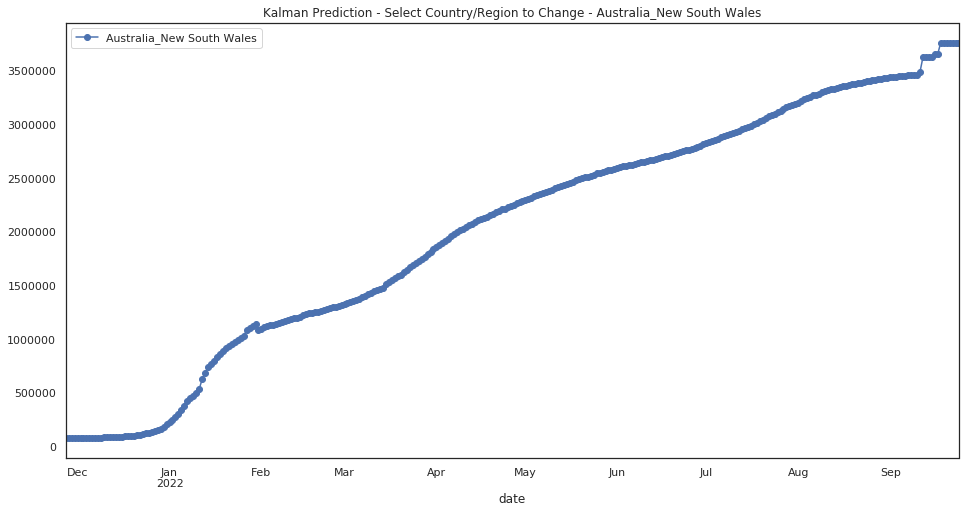

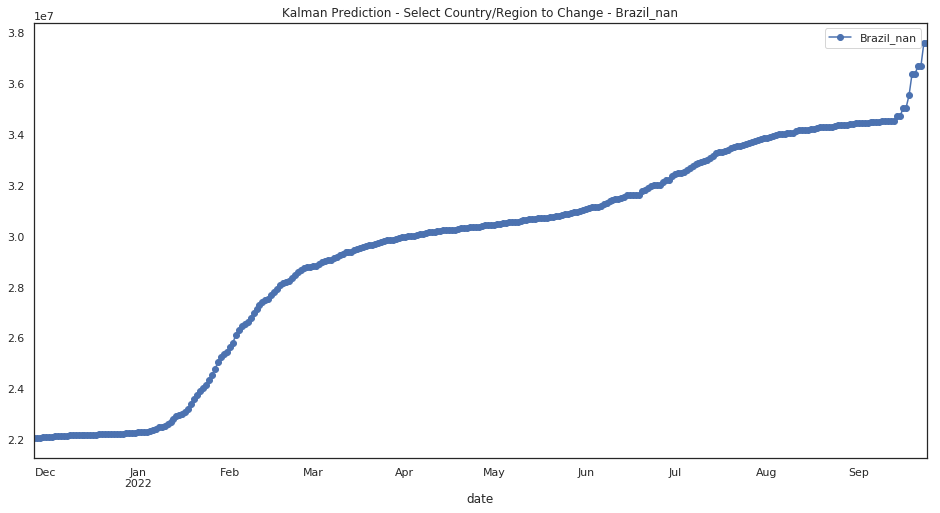

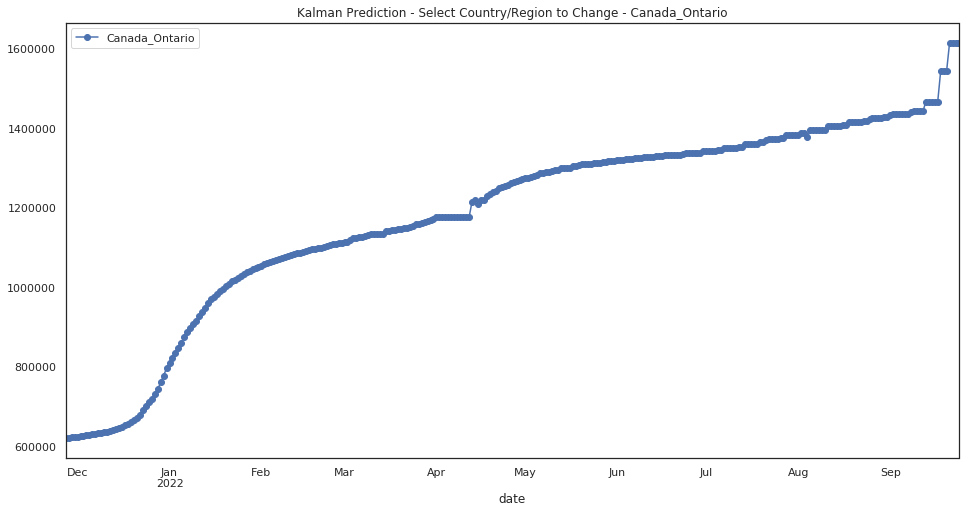

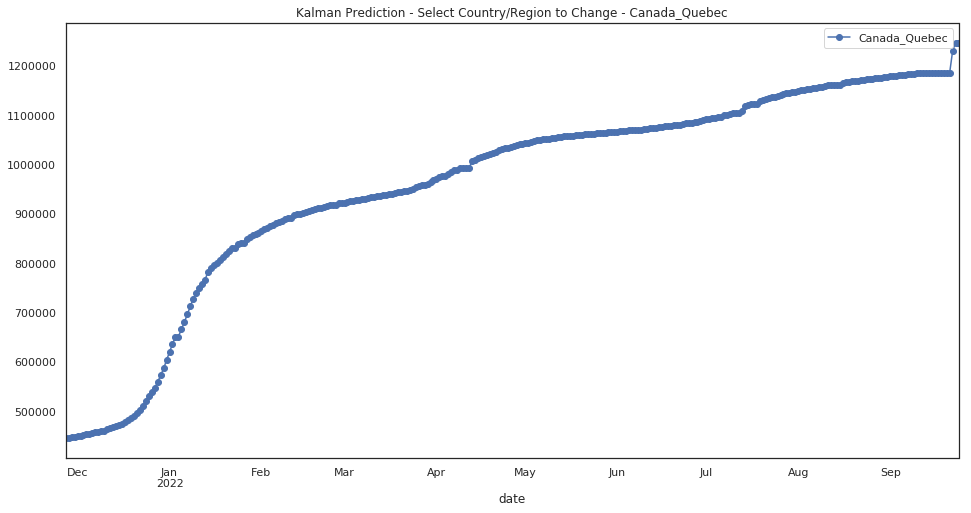

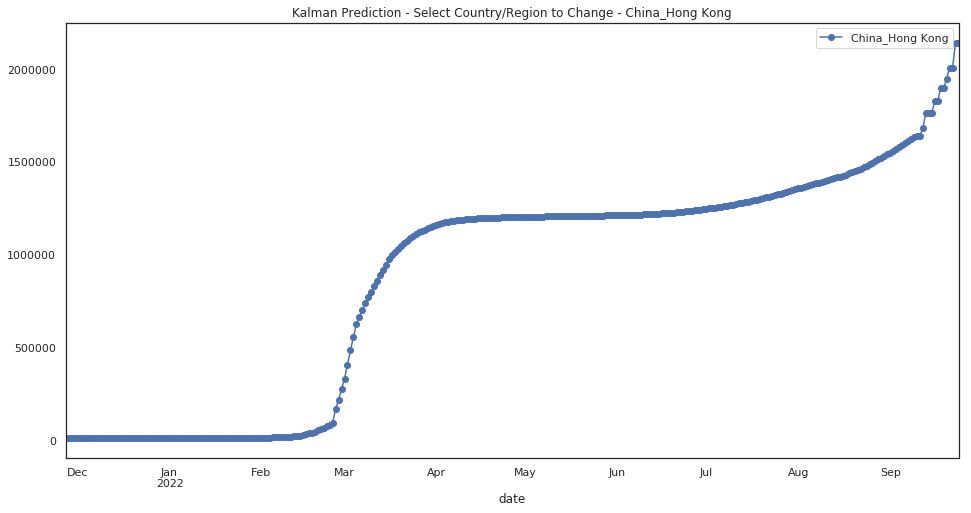

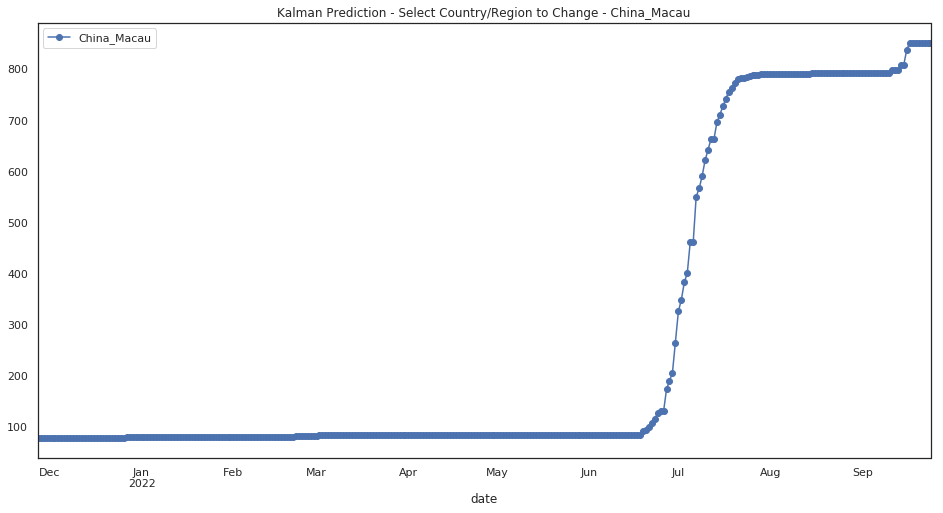

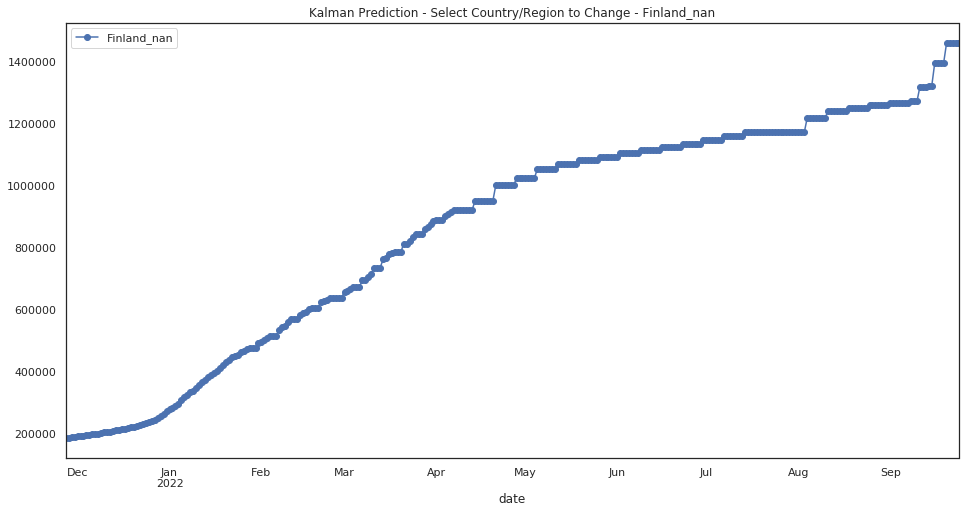

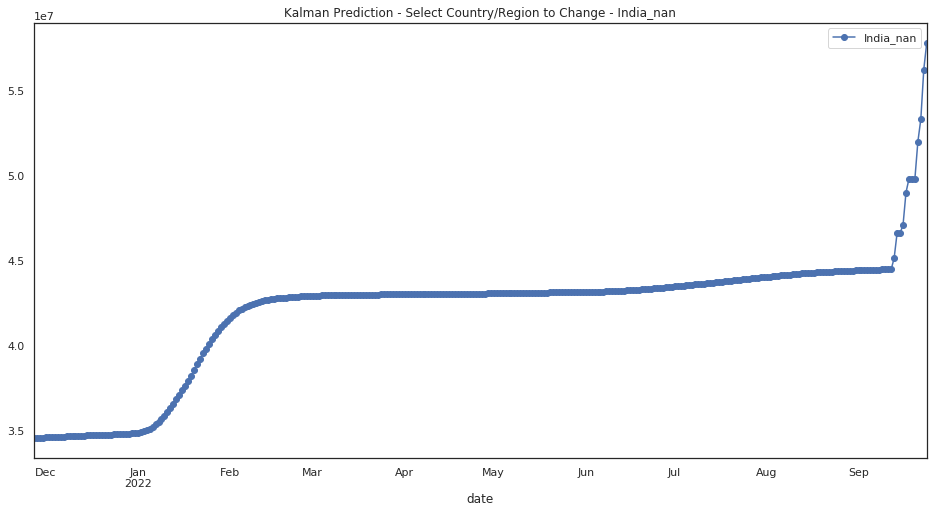

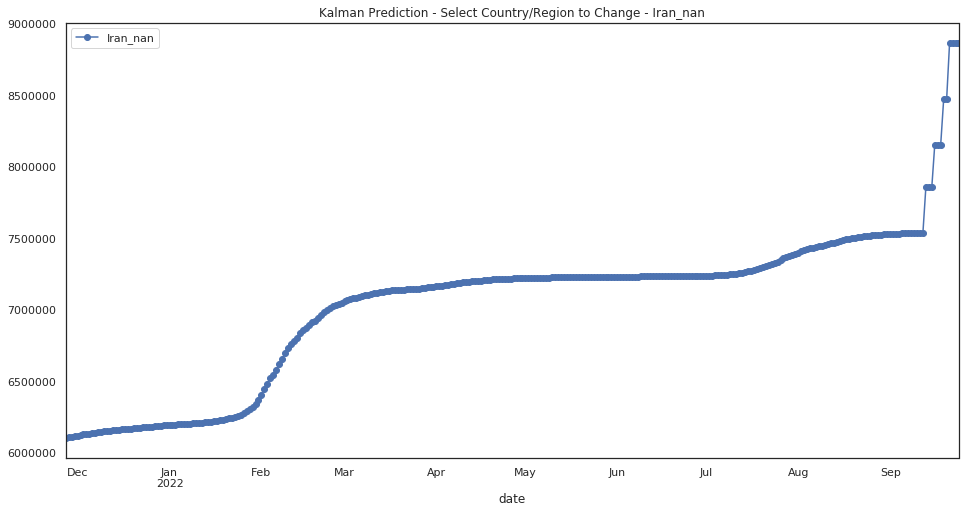

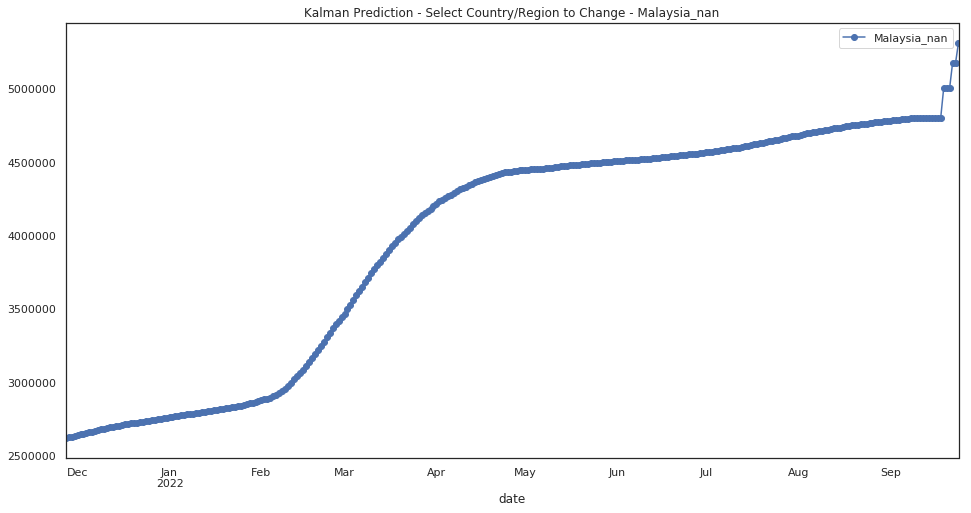

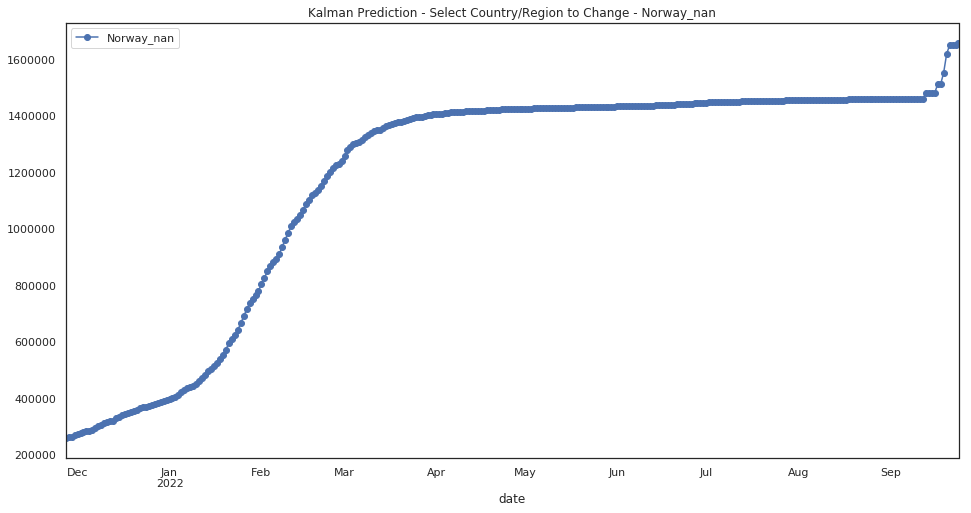

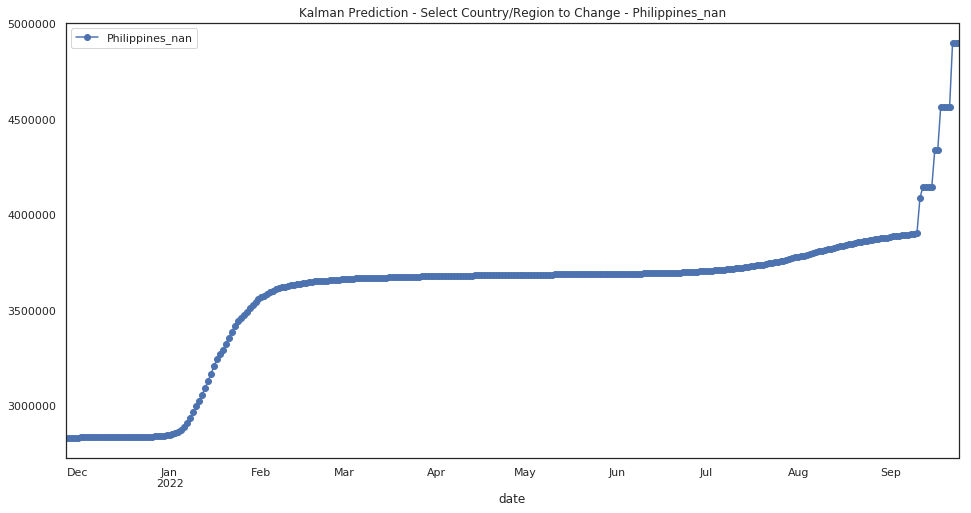

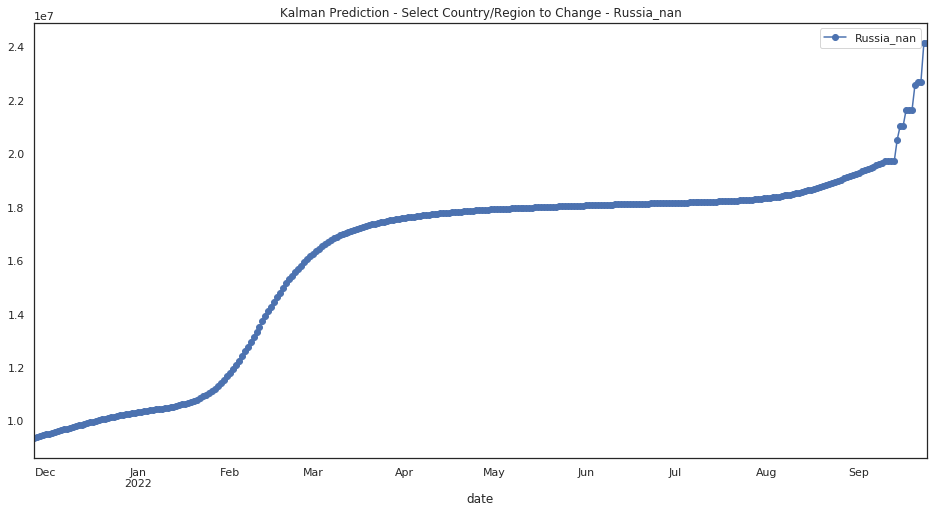

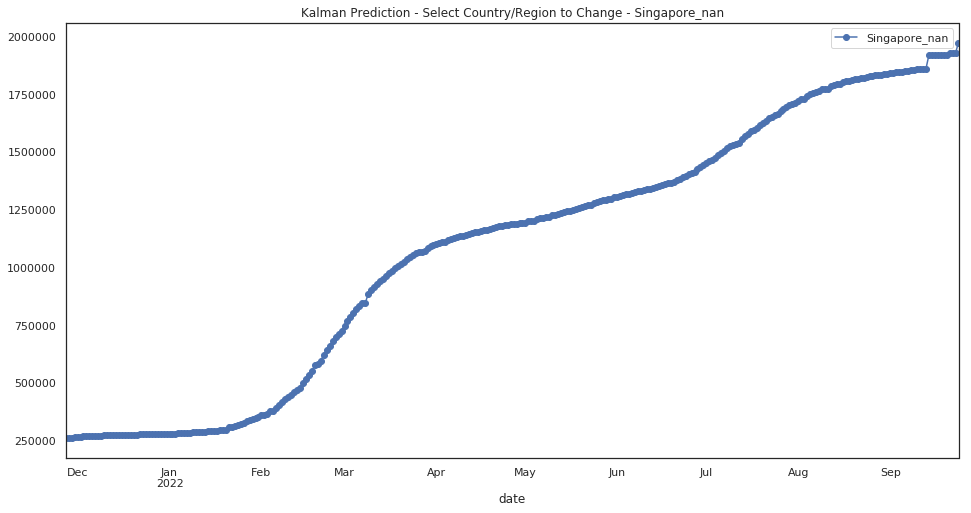

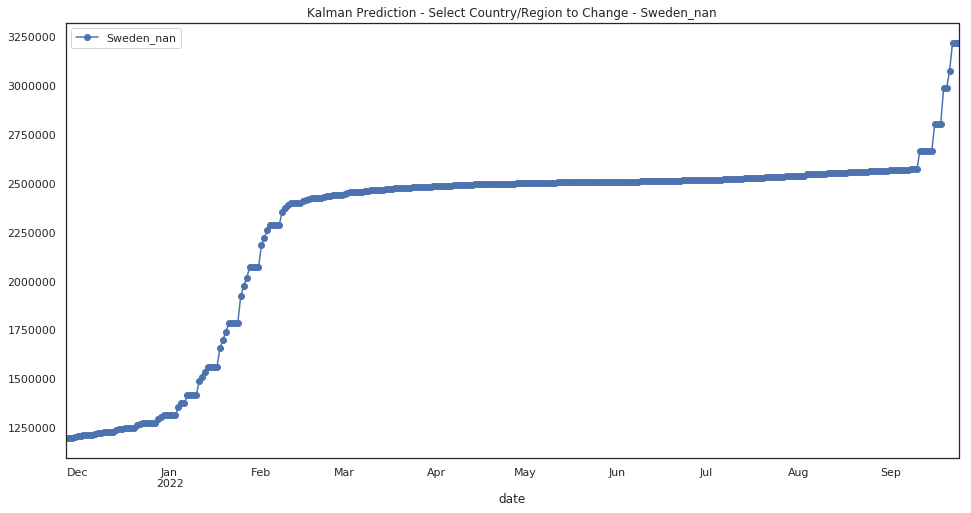

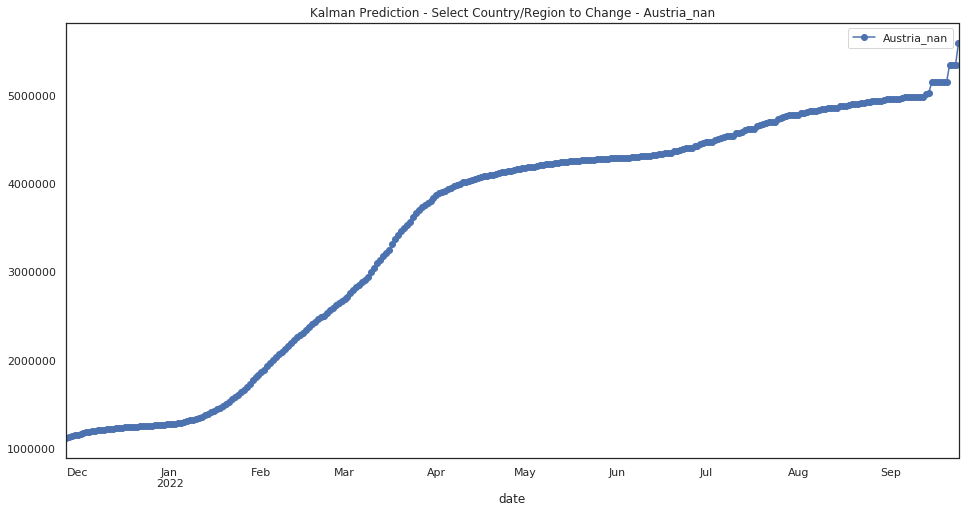

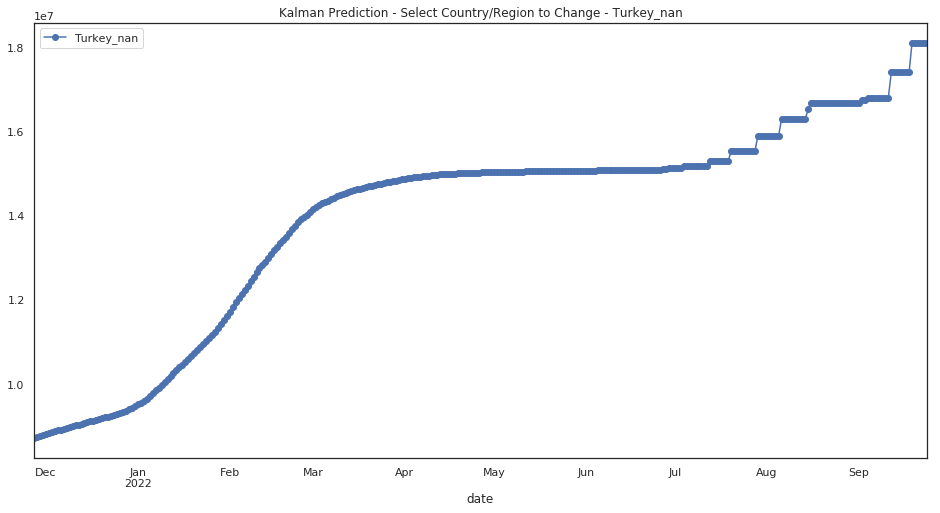

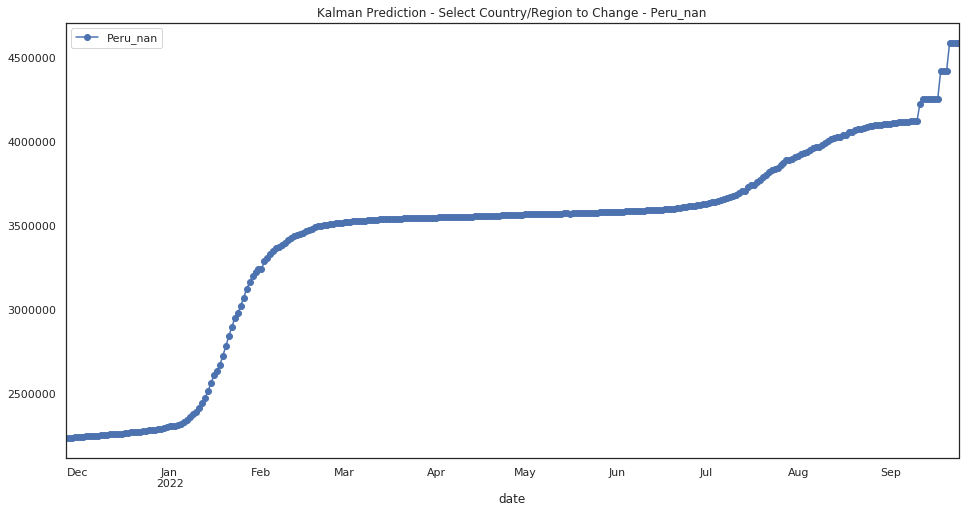

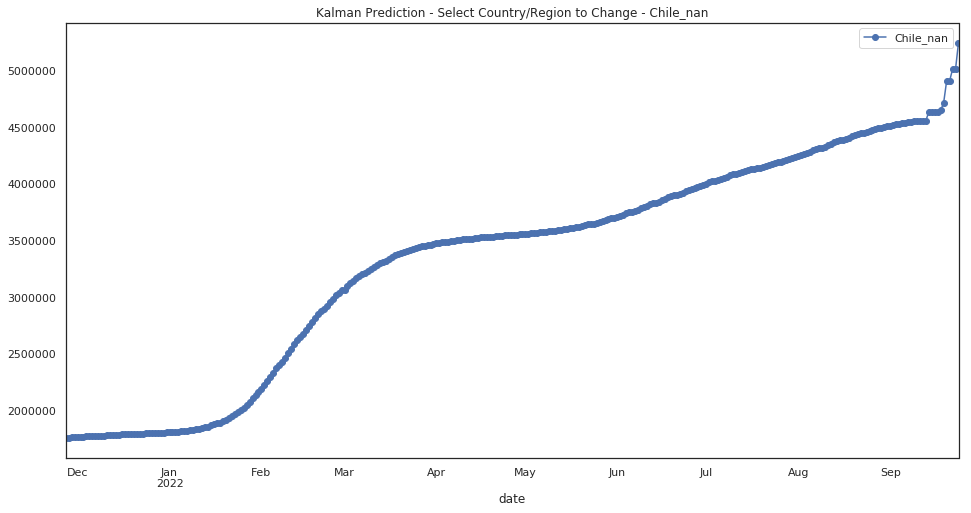

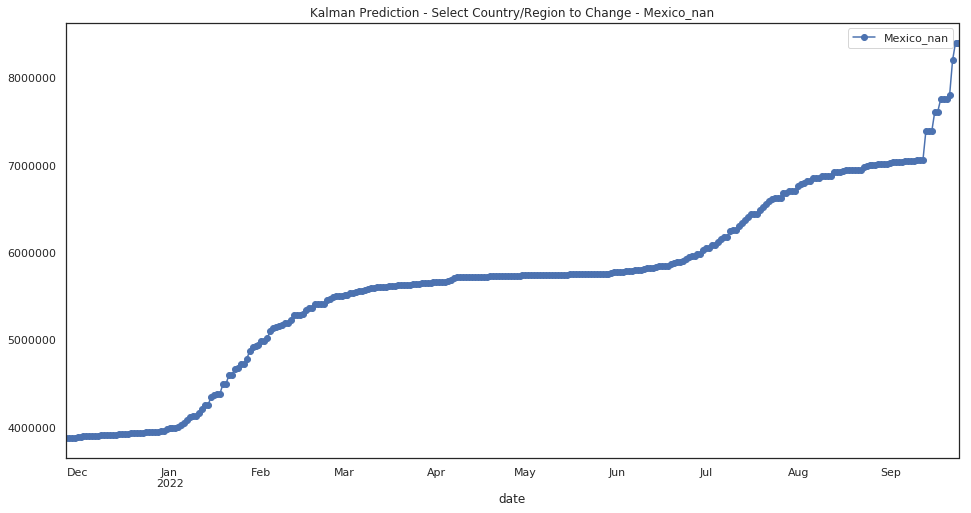

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-09-24 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN     114274307.0
India_nan                                           NaN      57843439.0
Germany_nan                                         NaN      42721895.0
France_nan                                          NaN      38549259.0
Brazil_nan                                          NaN      37596391.0
United Kingdom_nan                                  NaN      27953058.0
Italy_nan                                           NaN      27586007.0
Korea, South_nan                                    NaN      26600253.0
Russia_nan                                          NaN      24158055.0
Japan_nan                                           NaN      22281890.0
Turkey_nan                                          NaN      18109187.0
Spain_nan                                           NaN      14670198.0
Vietnam_nan                                         NaN      12798056.0
Argentina_nan                                       NaN      11245344.0
Netherlands_nan                                     NaN       9174283.0
Iran_nan                                            NaN       8867738.0
Mexico_nan                                          NaN       8406224.0
Poland_nan                                          NaN       7581335.0
Colombia_nan                                        NaN       7468750.0
Ukraine_nan                                         NaN       7387884.0
Indonesia_nan                                       NaN       7296795.0
Taiwan*_nan                                         NaN       6337660.0
Thailand_nan                                        NaN       5742360.0
Portugal_nan                                        NaN       5662044.0
Austria_nan                                         NaN       5600646.0
Malaysia_nan                                        NaN       5317520.0
South Africa_nan                                    NaN       5289020.0
Chile_nan                                           NaN       5249459.0
Belgium_nan                                         NaN       5067841.0
Philippines_nan                                     NaN       4902201.0
...                                                 ...             ...
China_Guangxi                                       NaN          2558.0
China_Tianjin                                       NaN          2472.0
China_Liaoning                                      NaN          2121.0
United Kingdom_Falkland Islands (Malvinas)          NaN          2019.0
China_Anhui                                         NaN          1717.0
China_Jiangxi                                       NaN          1690.0
United Kingdom_Montserrat                           NaN          1667.0
China_Hunan                                         NaN          1652.0
China_Gansu                                         NaN          1571.0
China_Tibet                                         NaN          1476.0
China_Xinjiang                                      NaN          1332.0
China_Chongqing                                     NaN          1198.0
Summer Olympics 2020_nan                            NaN           894.0
China_Macau                                         NaN           852.0
Diamond Princess_nan                                NaN           787.0
France_Wallis and Futuna                            NaN           775.0
Winter Olympics 2022_nan                            NaN           651.0
China_Shanxi                                        NaN           505.0
China_Qinghai                                       NaN           289.0
China_Guizhou                                       NaN           234.0
China_Ningxia                                       NaN           134.0
Holy See_nan                                        NaN            31.0
Canada_Repatriated Travellers                       NaN            16.0
Canada_Grand Princess                               NaN            15.0
Antarctica_nan        

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-11-27         274406.0     310300.0     319578.0     154200.0   
2021-11-28         274430.0     310657.0     319725.0     154200.0   
2021-11-29         157218.0     199555.0     210152.0      16712.0   
2021-11-30         157260.0     199750.0     210344.0      16712.0   
2021-12-01         157784.0     200213.0     211131.0      17115.0   
2021-12-02         157808.0     200633.0     211328.0      17426.0   
2021-12-03         157845.0     201034.0     211520.0      17658.0   
2021-12-04         157866.0     201412.0     211707.0      18010.0   
2021-12-05         159449.0     203197.0     213379.0      19117.0   
2021-12-06         159489.0     203394.0     213569.0      19508.0   
2021-12-07         159498.0     203762.0     213764.0      18631.0   
2021-12-08         159539.0     204083.0     213953.0      18815.0   
2021-12-09         159576.0     204321.0     214133.0      20365.0   
2021-12-10         159594.0     204681.0     214339.0      19272.0   
2021-12-11         159612.0     204986.0     214554.0      19440.0   
2021-12-12         159634.0     205260.0     214752.0      20431.0   
2021-12-13         159645.0     205425.0     214960.0      20179.0   
2021-12-14         159661.0     205772.0     215186.0      20670.0   
2021-12-15         159668.0     206087.0     215426.0      20136.0   
2021-12-16         159723.0     206399.0     215640.0      21448.0   
2021-12-17         159724.0     206699.0     215926.0      20549.0   
2021-12-18         159751.0     207020.0     216207.0      21313.0   
2021-12-19         159788.0     207259.0     216471.0      21313.0   
2021-12-20         159791.0     207401.0     216716.0      21542.0   
2021-12-21         159818.0     207743.0     217013.0      21062.0   
2021-12-22         159840.0     208072.0     217295.0      22093.0   
2021-12-23         159871.0     208400.0     217586.0      21372.0   
2021-12-24         159883.0     208698.0     217946.0      21571.0   
2021-12-25         159900.0     209014.0     218233.0      21730.0   
2021-12-26         159948.0     209199.0     218501.0      22363.0   
...                     ...          ...          ...          ...   
2022-08-27         193901.0     329538.0     272136.0      46027.0   
2022-08-28         194322.0     329776.0     272157.0      46027.0   
2022-08-29         194695.0     329836.0     272196.0      46027.0   
2022-08-30         194866.0     330192.0     272239.0      46027.0   
2022-08-31         195145.0     330630.0     272274.0      46027.0   
2022-09-01         195388.0     330890.0     272328.0      46027.0   
2022-09-02         195424.0     331135.0     272377.0      46027.0   
2022-09-03         195789.0     331341.0     272401.0      46027.0   
2022-09-04         195995.0     331479.0     272417.0      46027.0   
2022-09-05         196227.0     331511.0     272434.0      46027.0   
2022-09-06         196505.0     331546.0     272450.0      46027.0   
2022-09-07         196861.0     331782.0     272464.0      46027.0   
2022-09-08         197143.0     332003.0     272482.0      46113.0   
2022-09-09         197349.0     332155.0     272500.0      46113.0   
2022-09-10         197511.0     332272.0     272512.0      46113.0   
2022-09-11         197540.0     332281.0     278014.0      46113.0   
2022-09-12         198445.0     332265.0     283363.0      46727.0   
2022-09-13         198458.0     333036.0     283771.0      48420.0   
2022-09-14         200145.0     333305.0     283257.0      48420.0   
2022-09-15         200192.0     333141.0     283099.0      48420.0   
2022-09-16         200372.0     333324.0     282991.0      48420.0   
2022-09-17         202666.0     338519.0     292719.0      48420.0   
2022-09-18         202656.0     340267.0     299798.0      48606.0   
2022-09-19         202937.0     339073.0     300137.0      48606.0   
2022-09-20

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Germany_nan',
 'France_nan',
 'Brazil_nan',
 'United Kingdom_nan',
 'Italy_nan',
 'Korea, South_nan',
 'Russia_nan',
 'Japan_nan',
 'Turkey_nan',
 'Spain_nan',
 'Vietnam_nan',
 'Argentina_nan',
 'Netherlands_nan',
 'Iran_nan',
 'Mexico_nan',
 'Poland_nan',
 'Colombia_nan',
 'Ukraine_nan',
 'Indonesia_nan',
 'Taiwan*_nan',
 'Thailand_nan',
 'Portugal_nan',
 'Austria_nan',
 'Malaysia_nan',
 'South Africa_nan',
 'Chile_nan',
 'Belgium_nan',
 'Philippines_nan',
 'Greece_nan',
 'Switzerland_nan',
 'Czechia_nan',
 'Israel_nan',
 'Peru_nan',
 'Denmark_nan',
 'Australia_New South Wales',
 'Romania_nan',
 'Slovakia_nan',
 'Sweden_nan',
 'Australia_Victoria',
 'Serbia_nan',
 'Iraq_nan',
 'Bangladesh_nan',
 'Hungary_nan',
 'China_Hong Kong',
 'Jordan_nan',
 'Singapore_nan',
 'Georgia_nan',
 'Pakistan_nan',
 'Ireland_nan',
 'New Zealand_nan',
 'Australia_Queensland',
 'Norway_nan',
 'Kazakhstan_nan',
 'Canada_Ontario',
 'Morocco_nan',
 'Finland_nan',
 'Lebanon

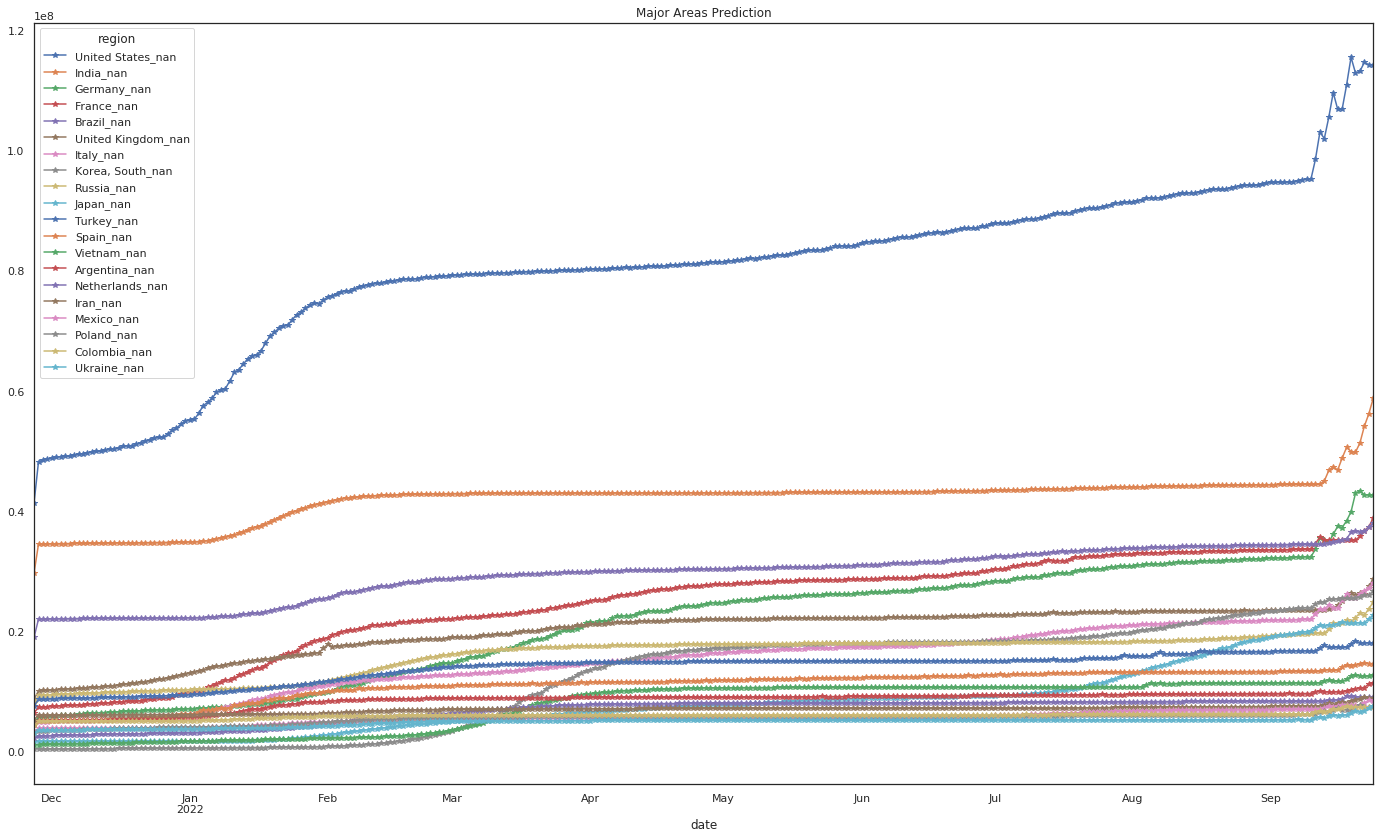

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

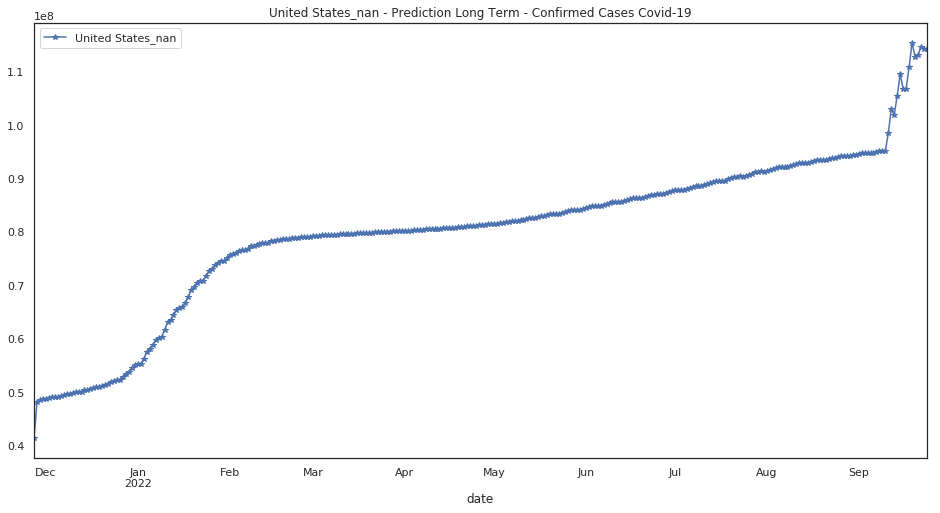

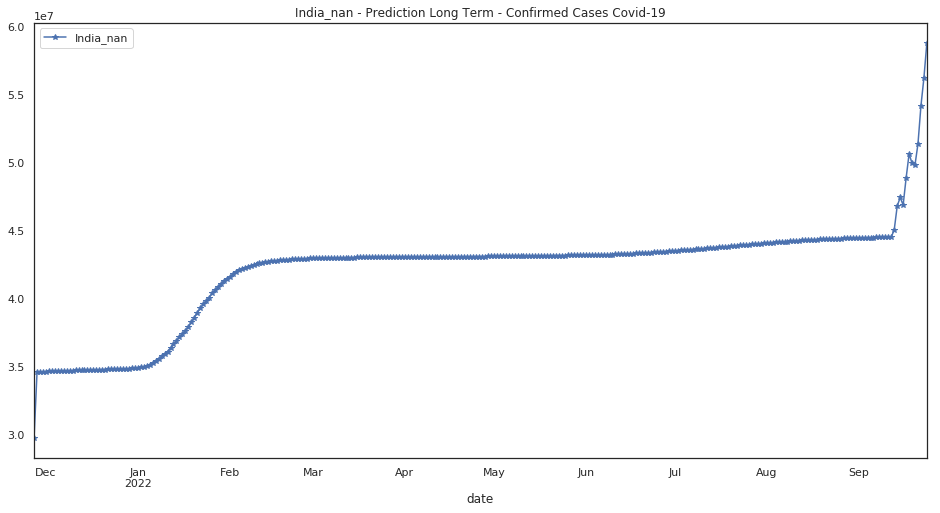

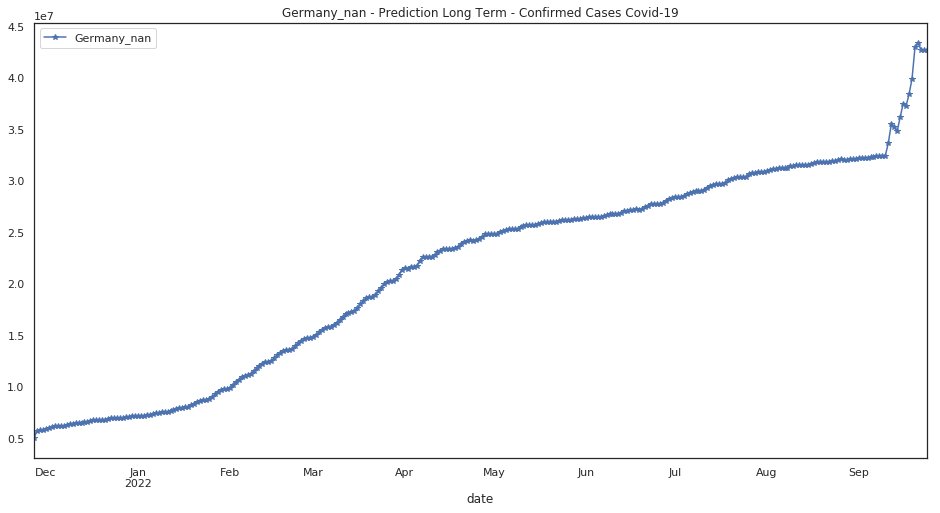

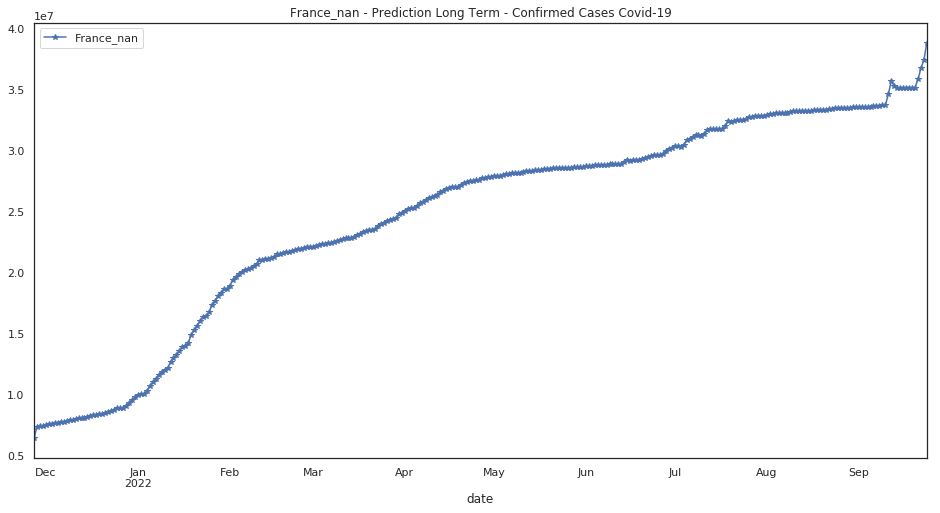

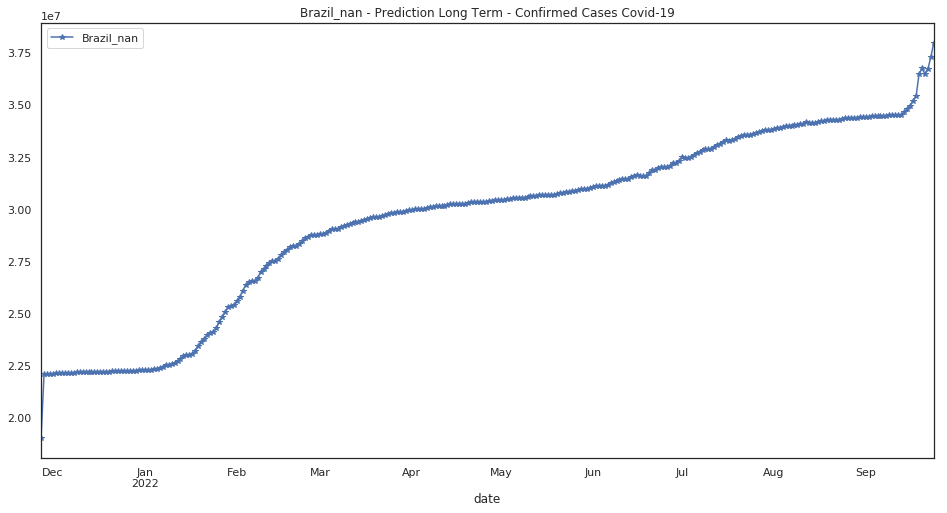

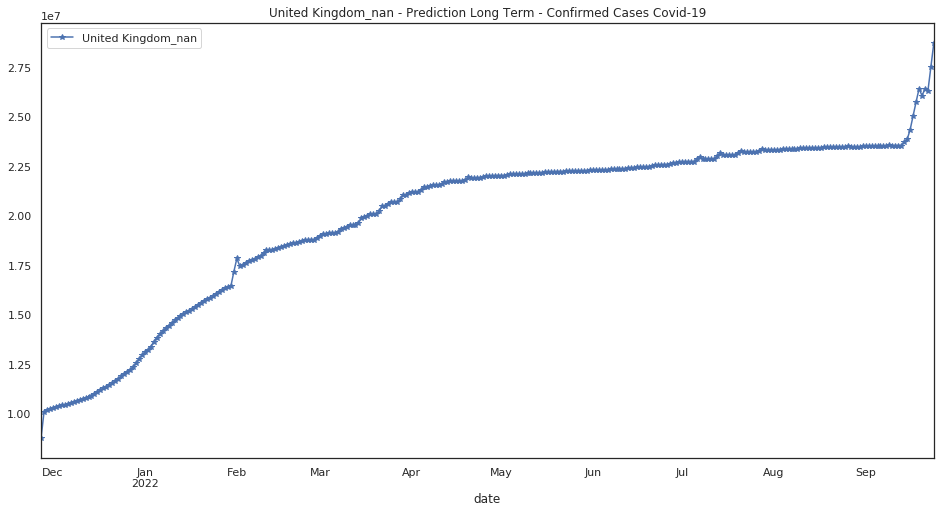

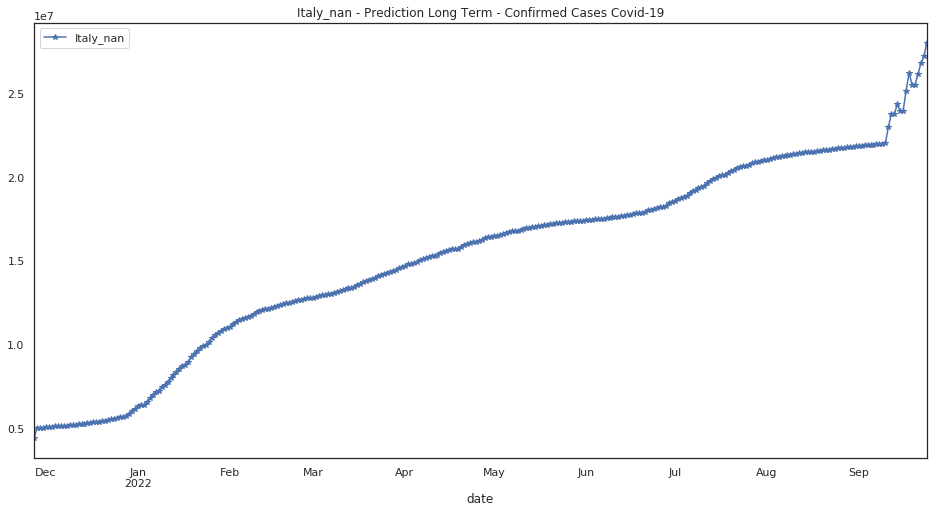

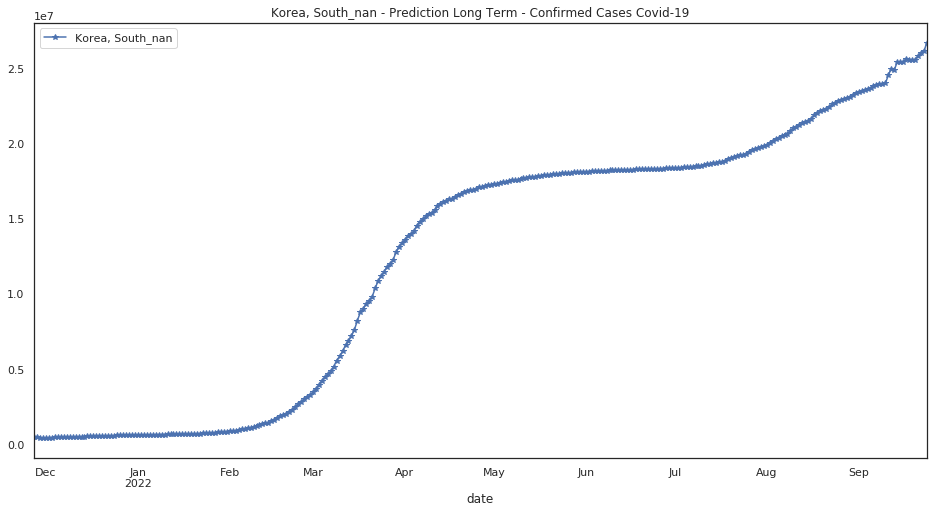

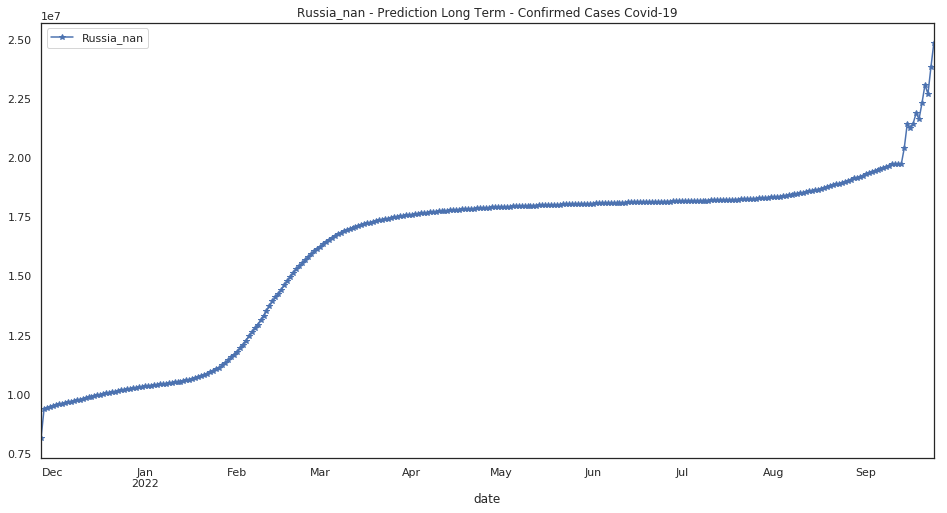

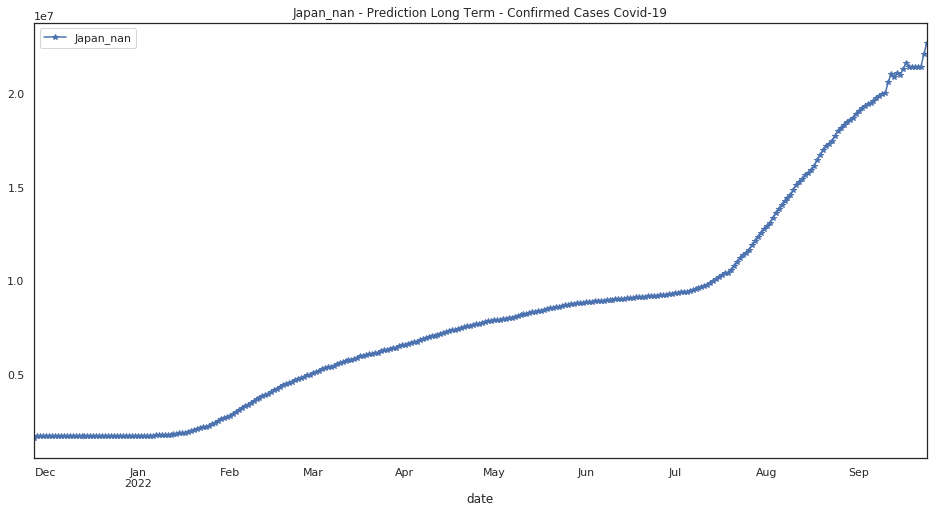

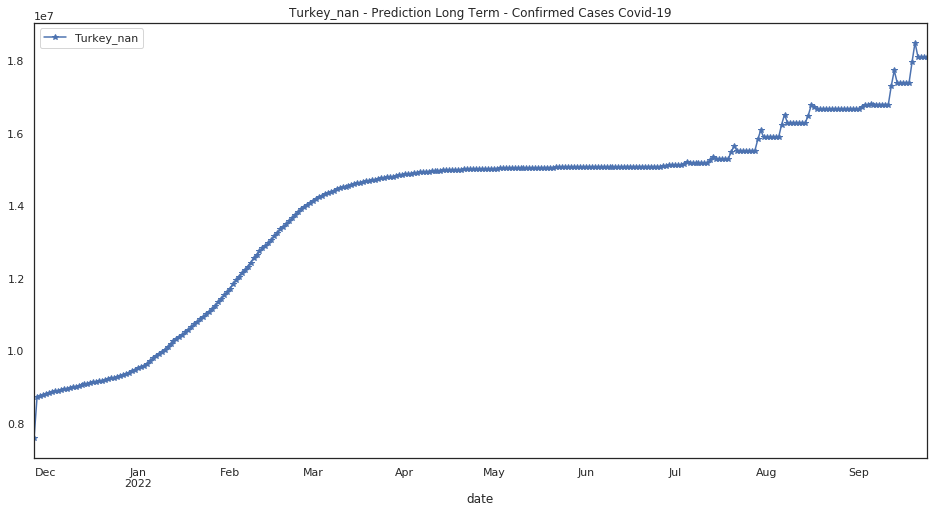

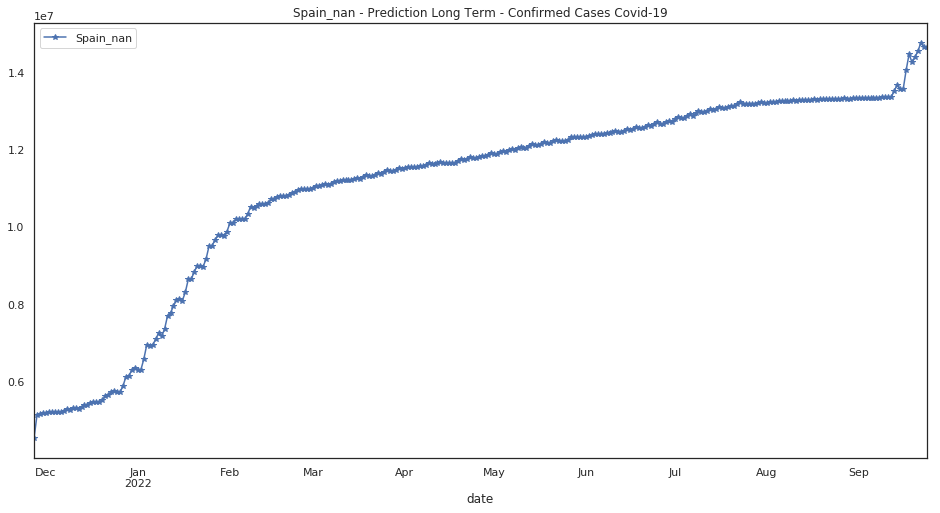

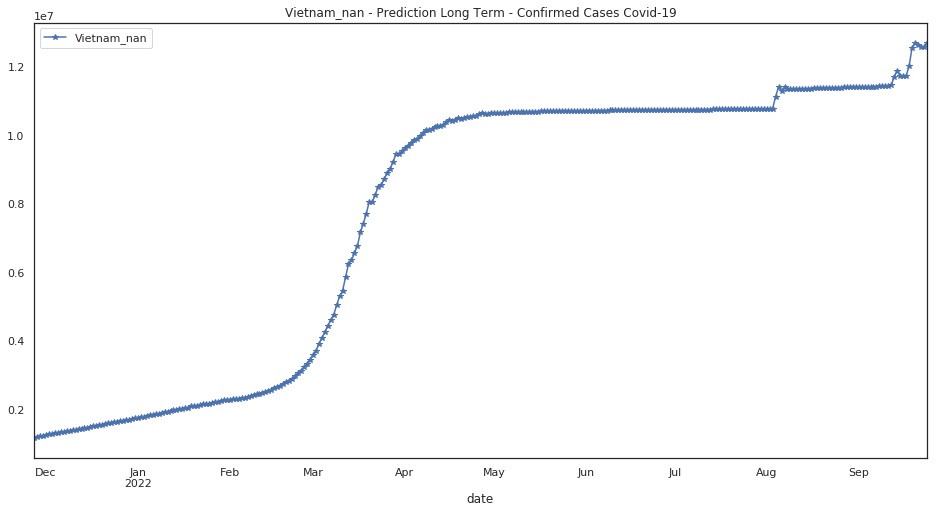

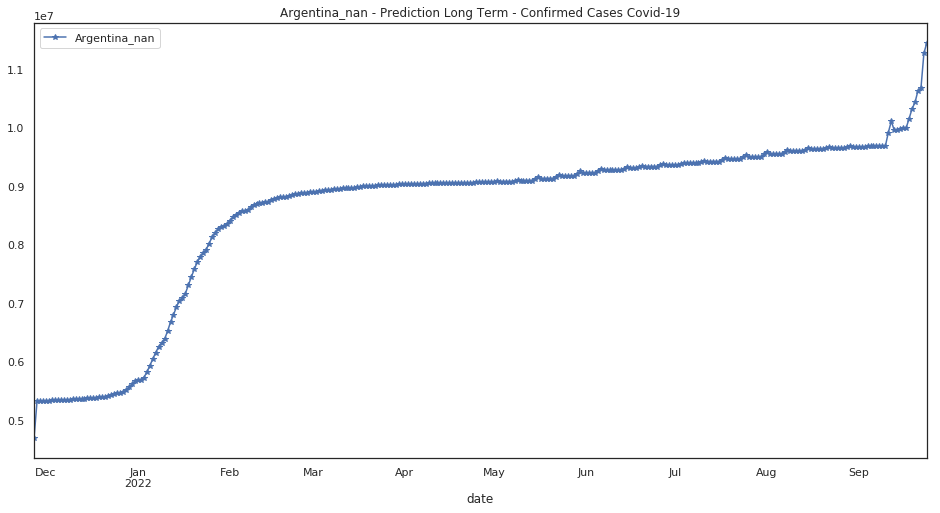

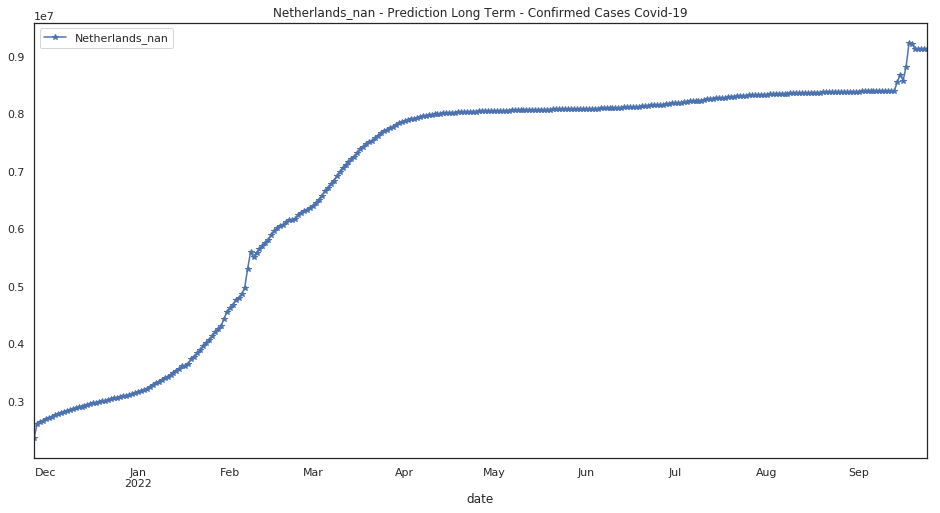

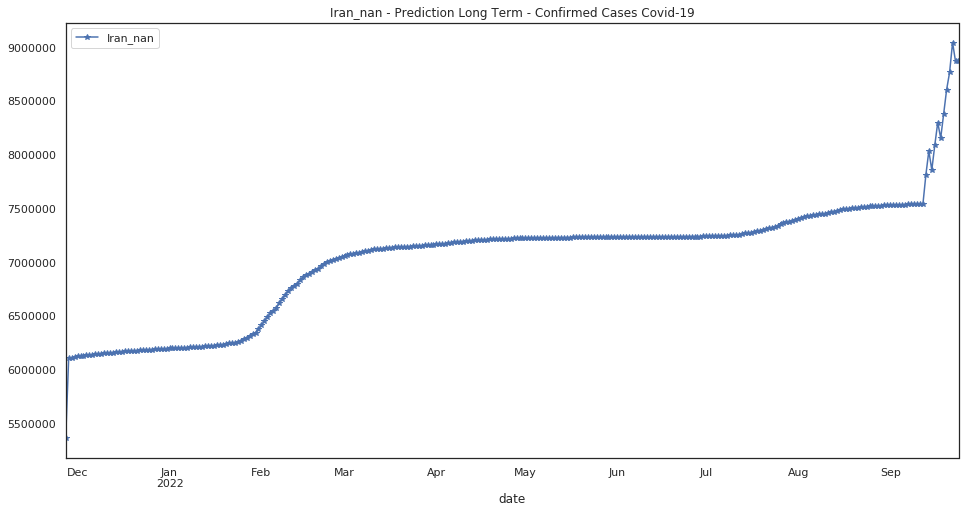

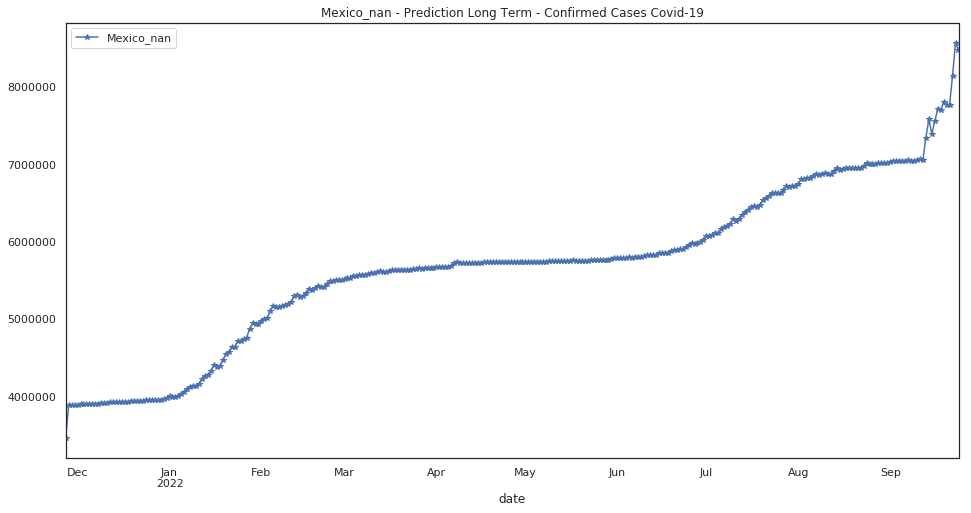

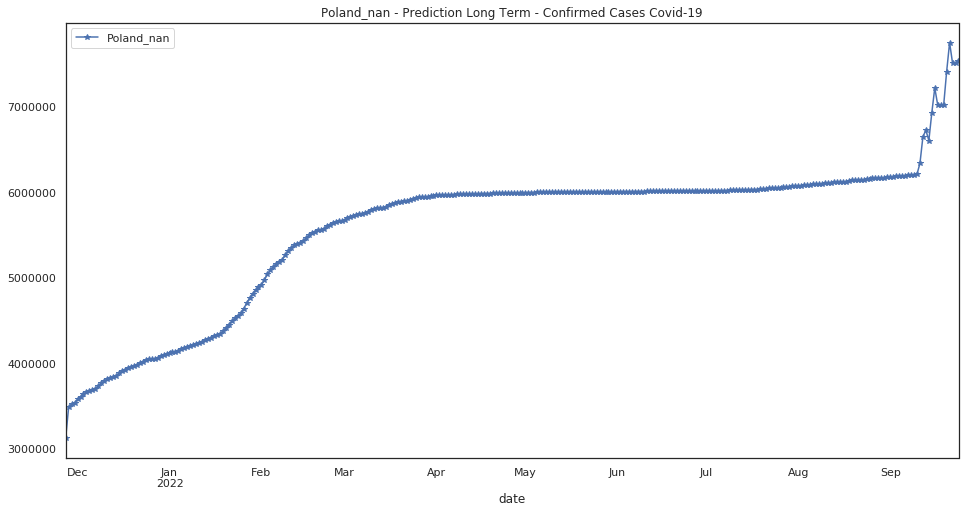

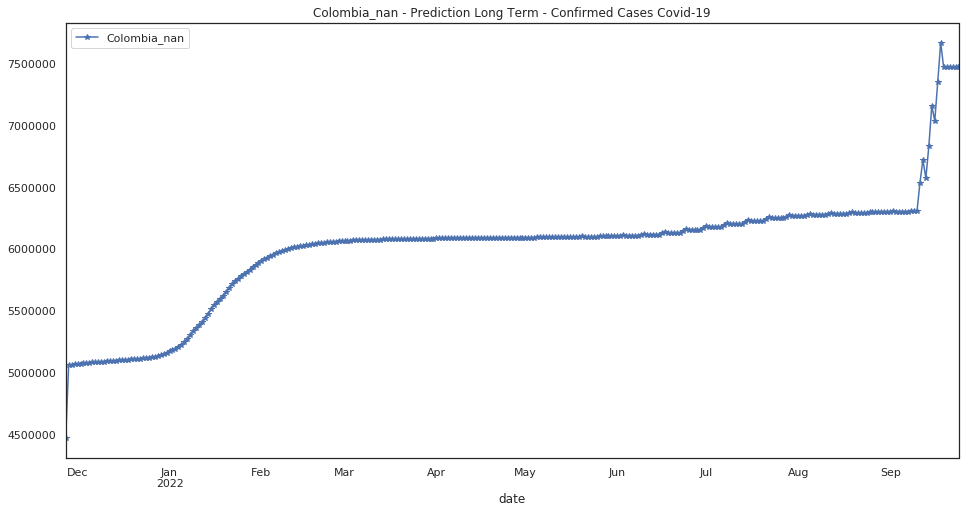

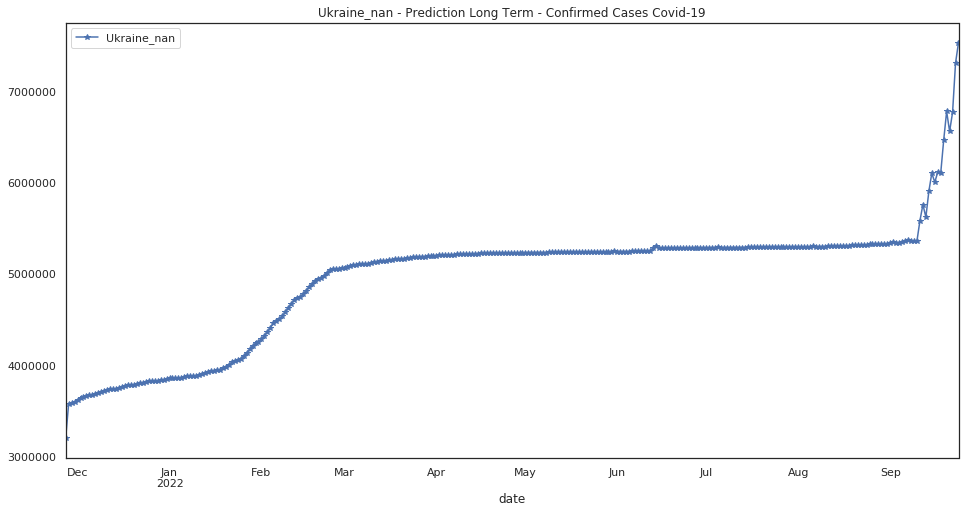

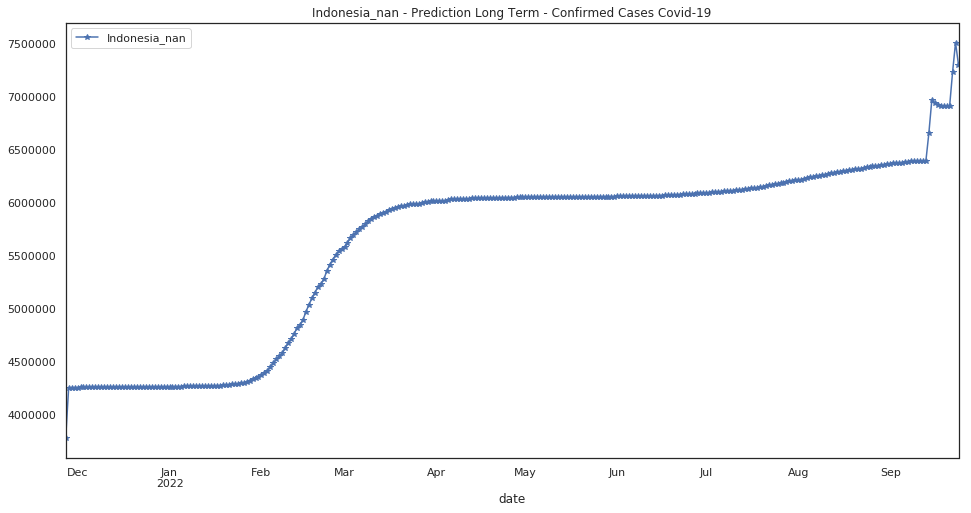

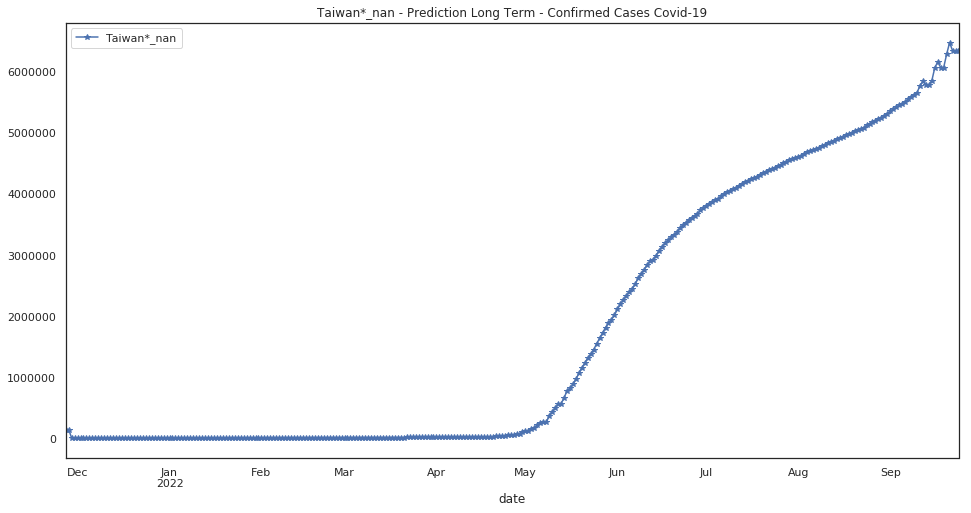

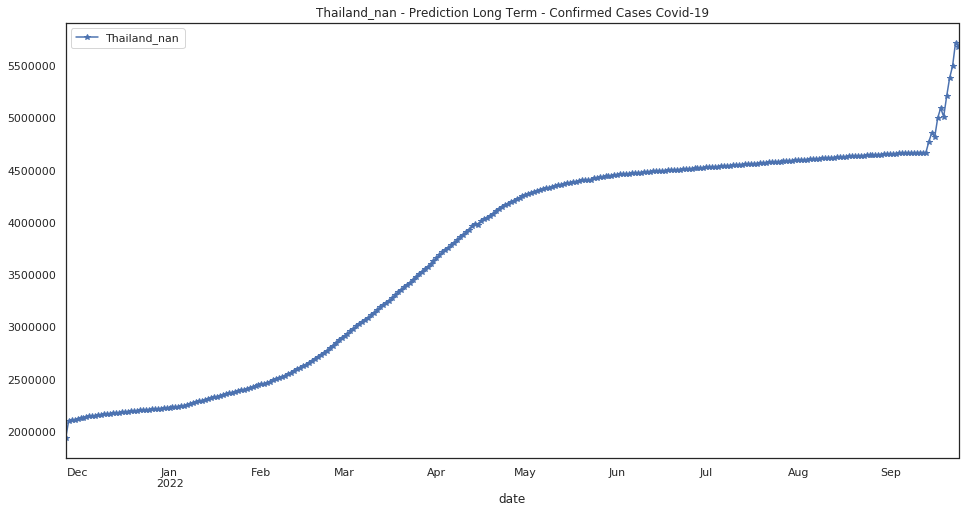

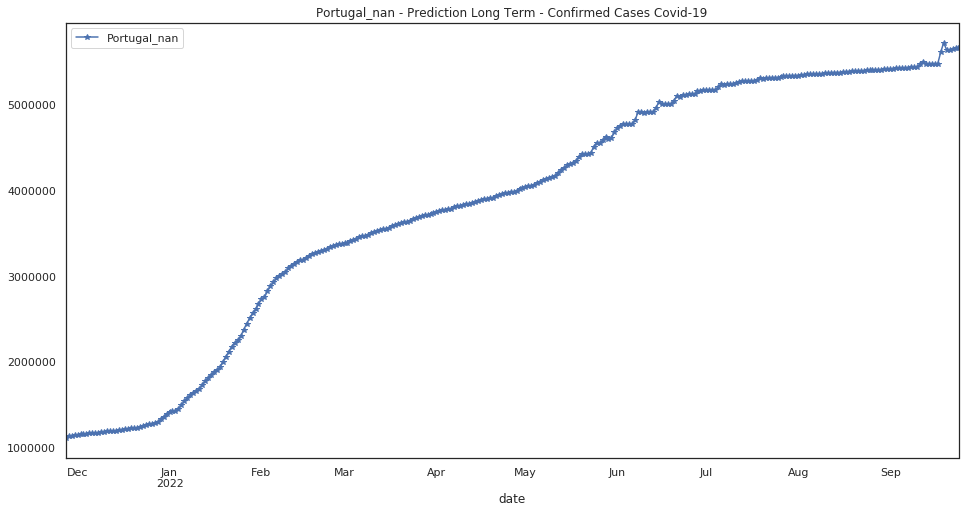

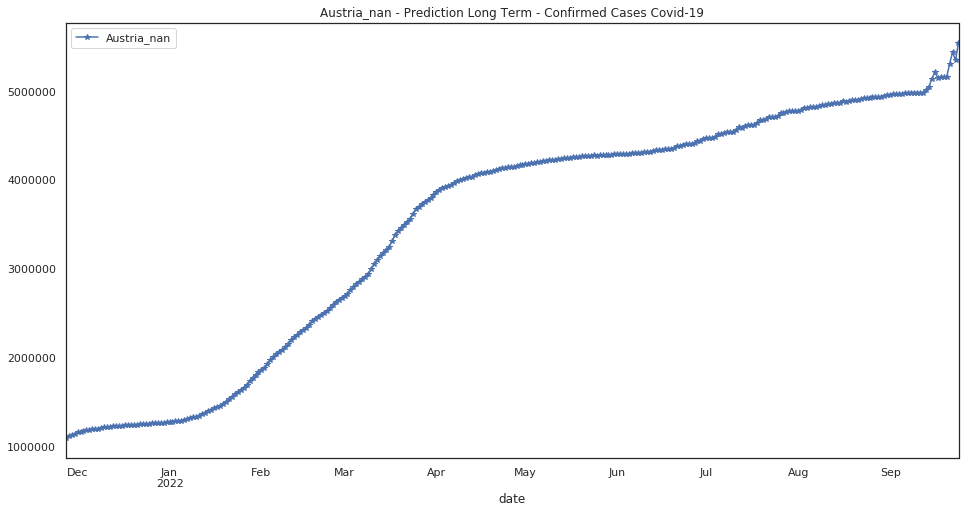

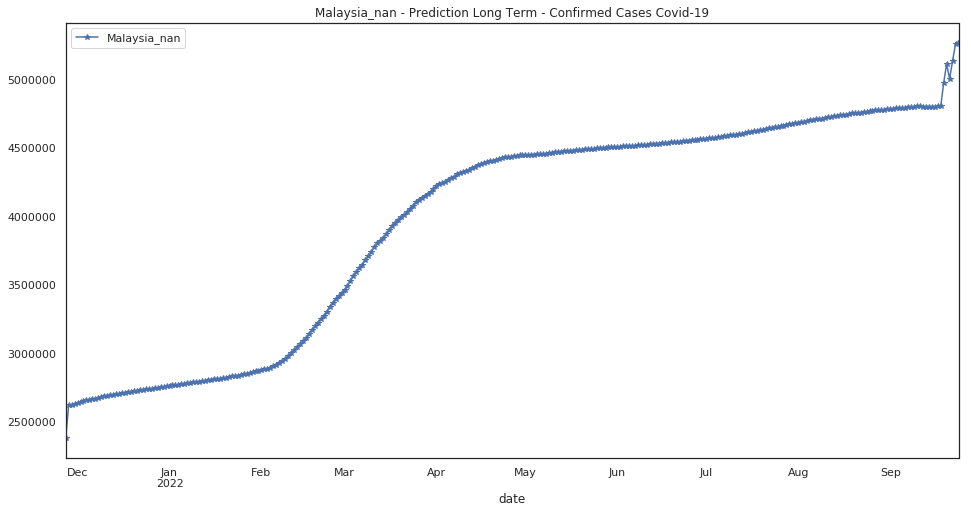

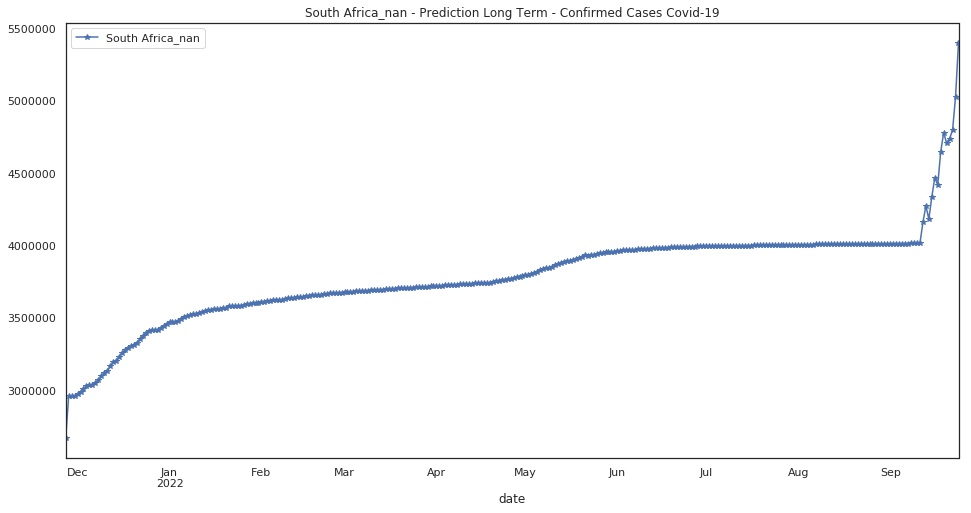

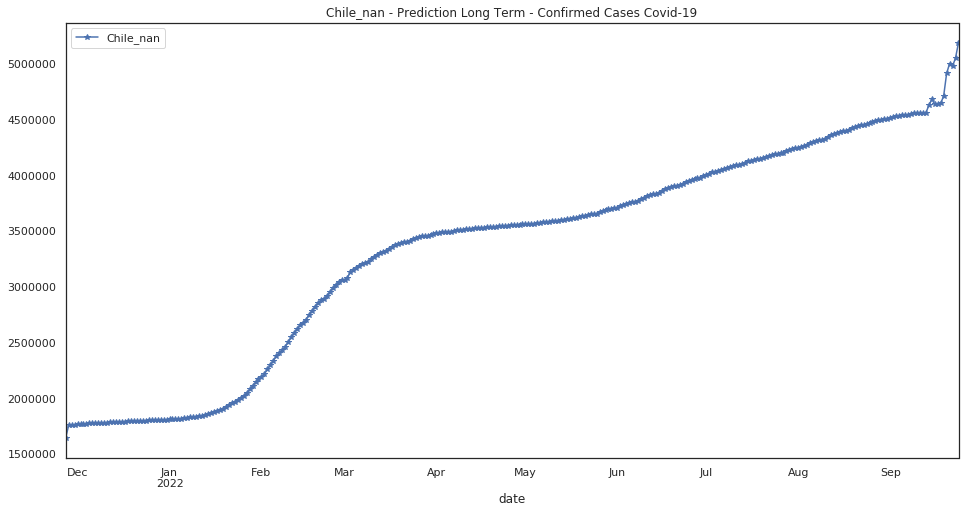

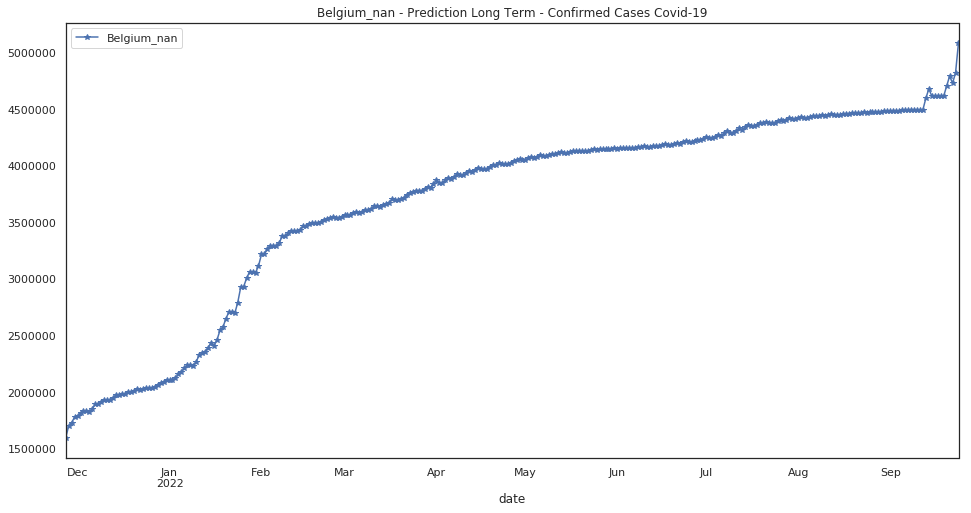

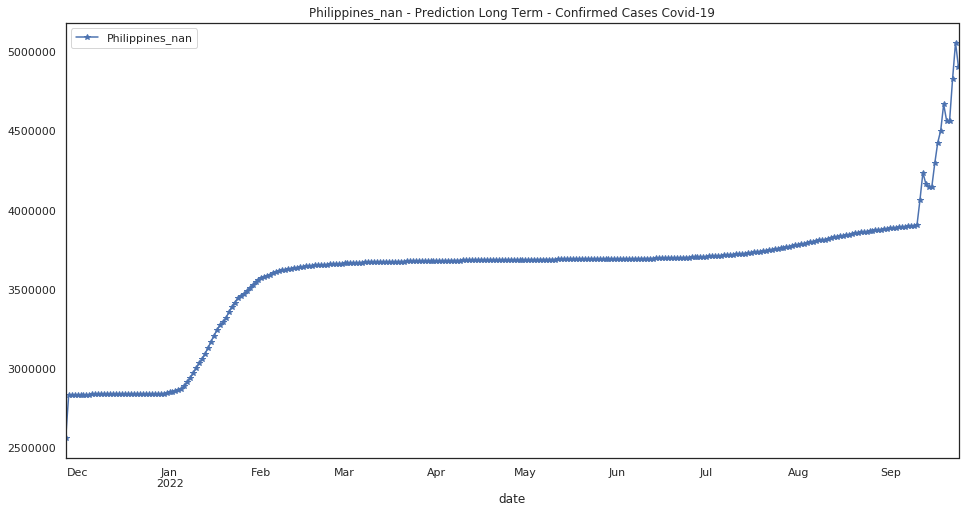

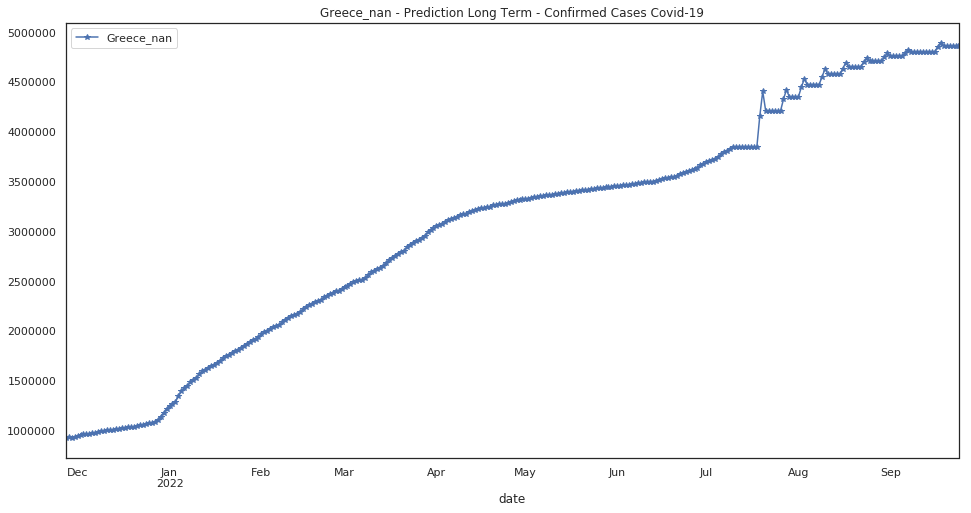

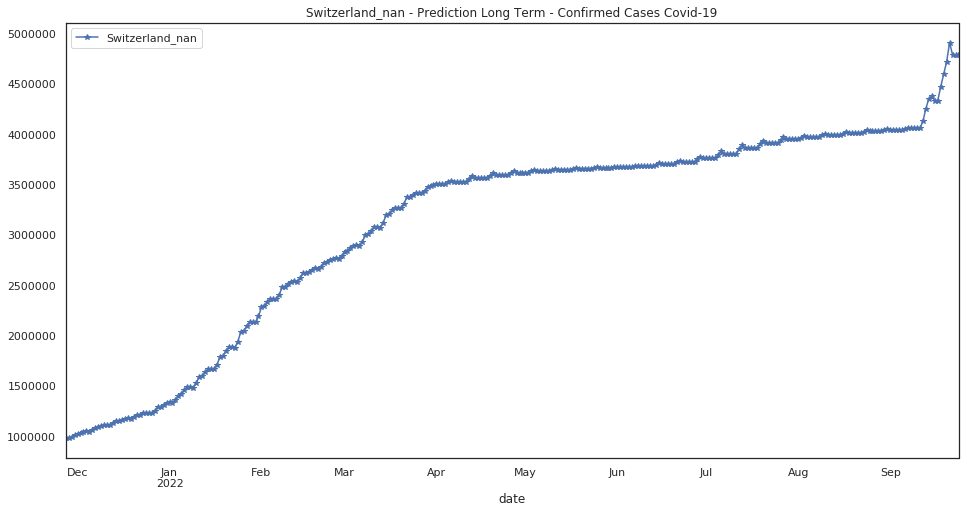

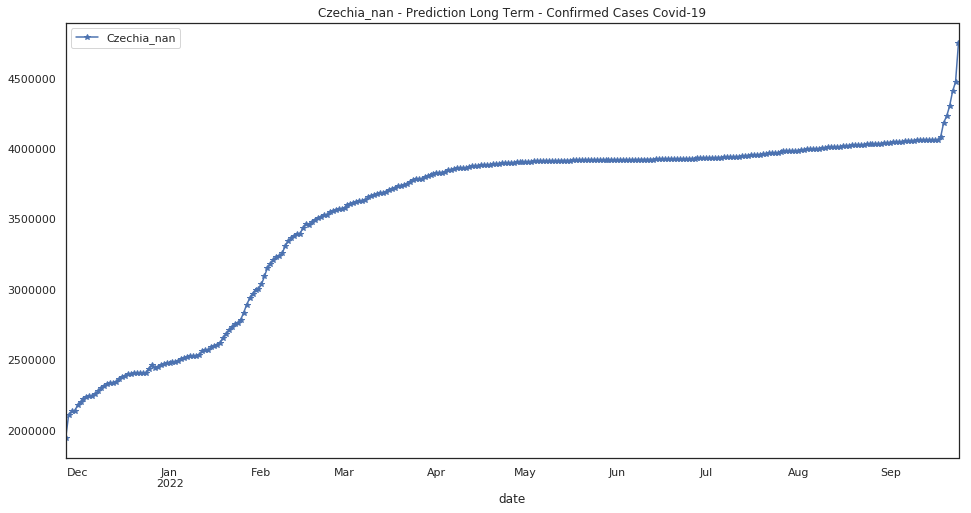

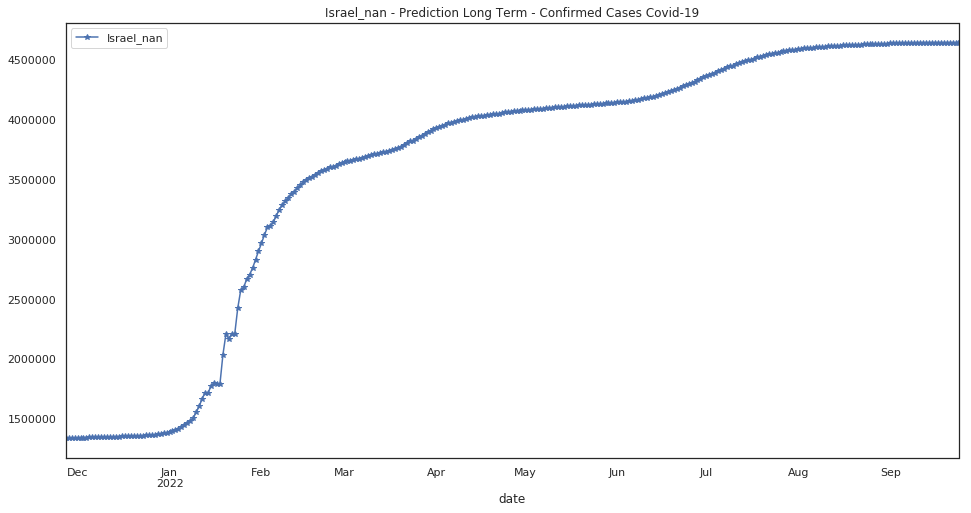

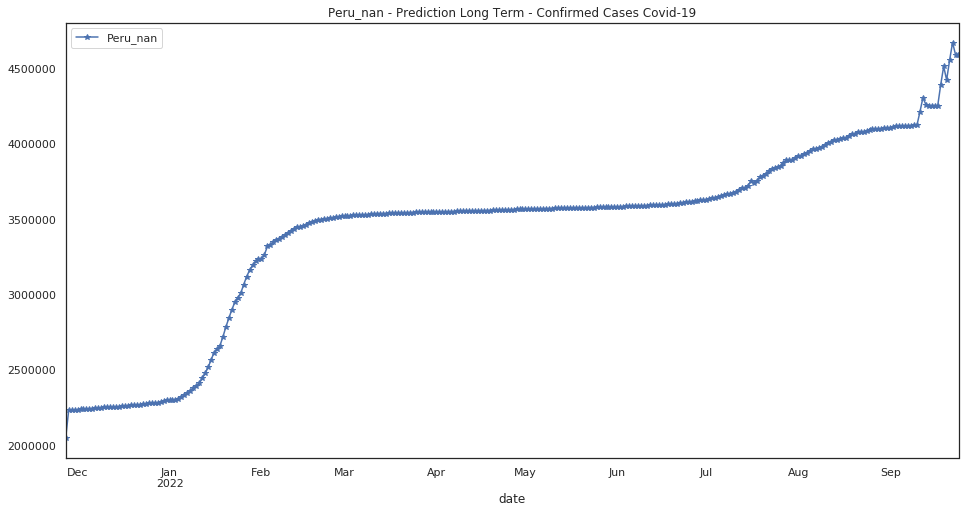

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

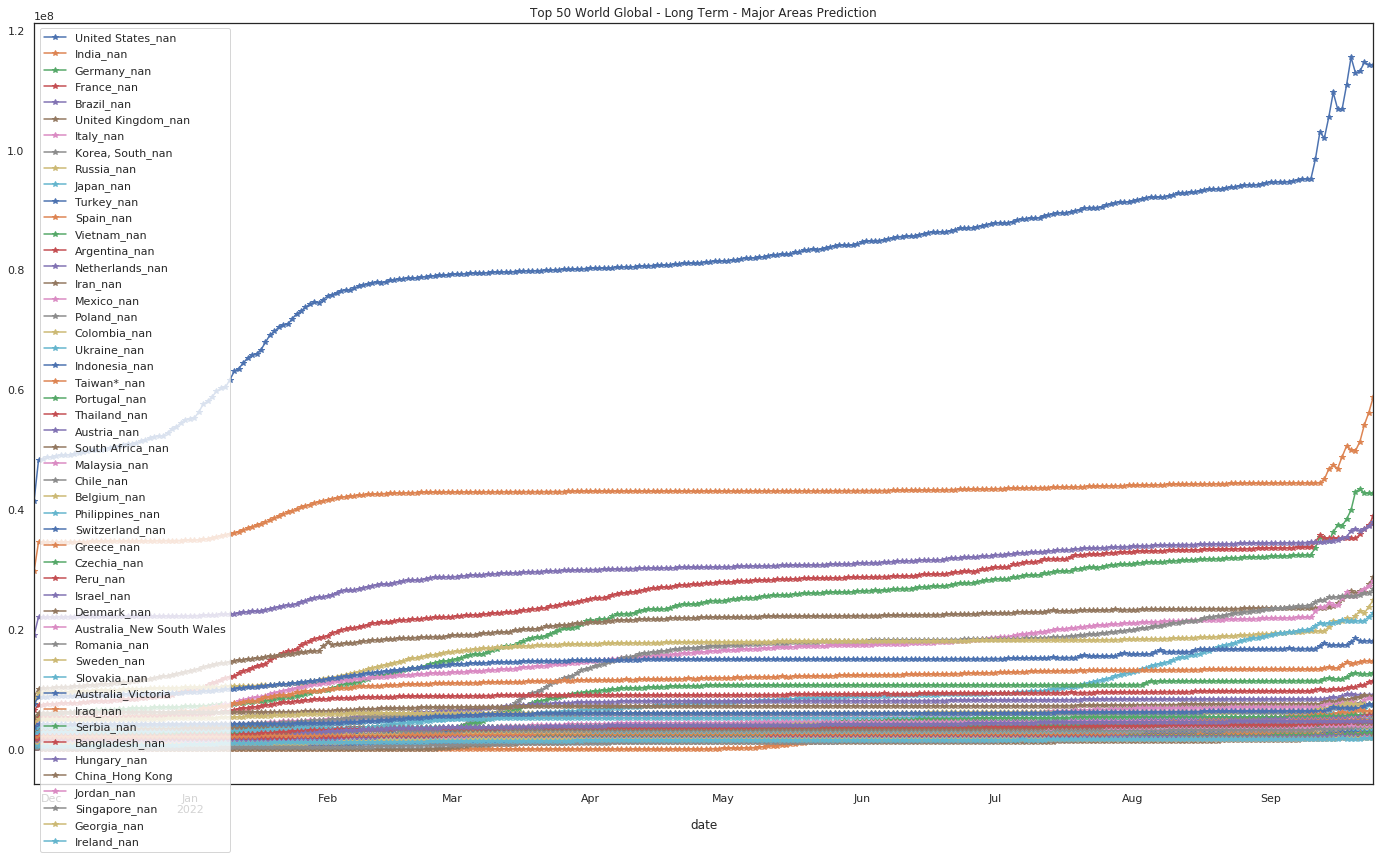

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

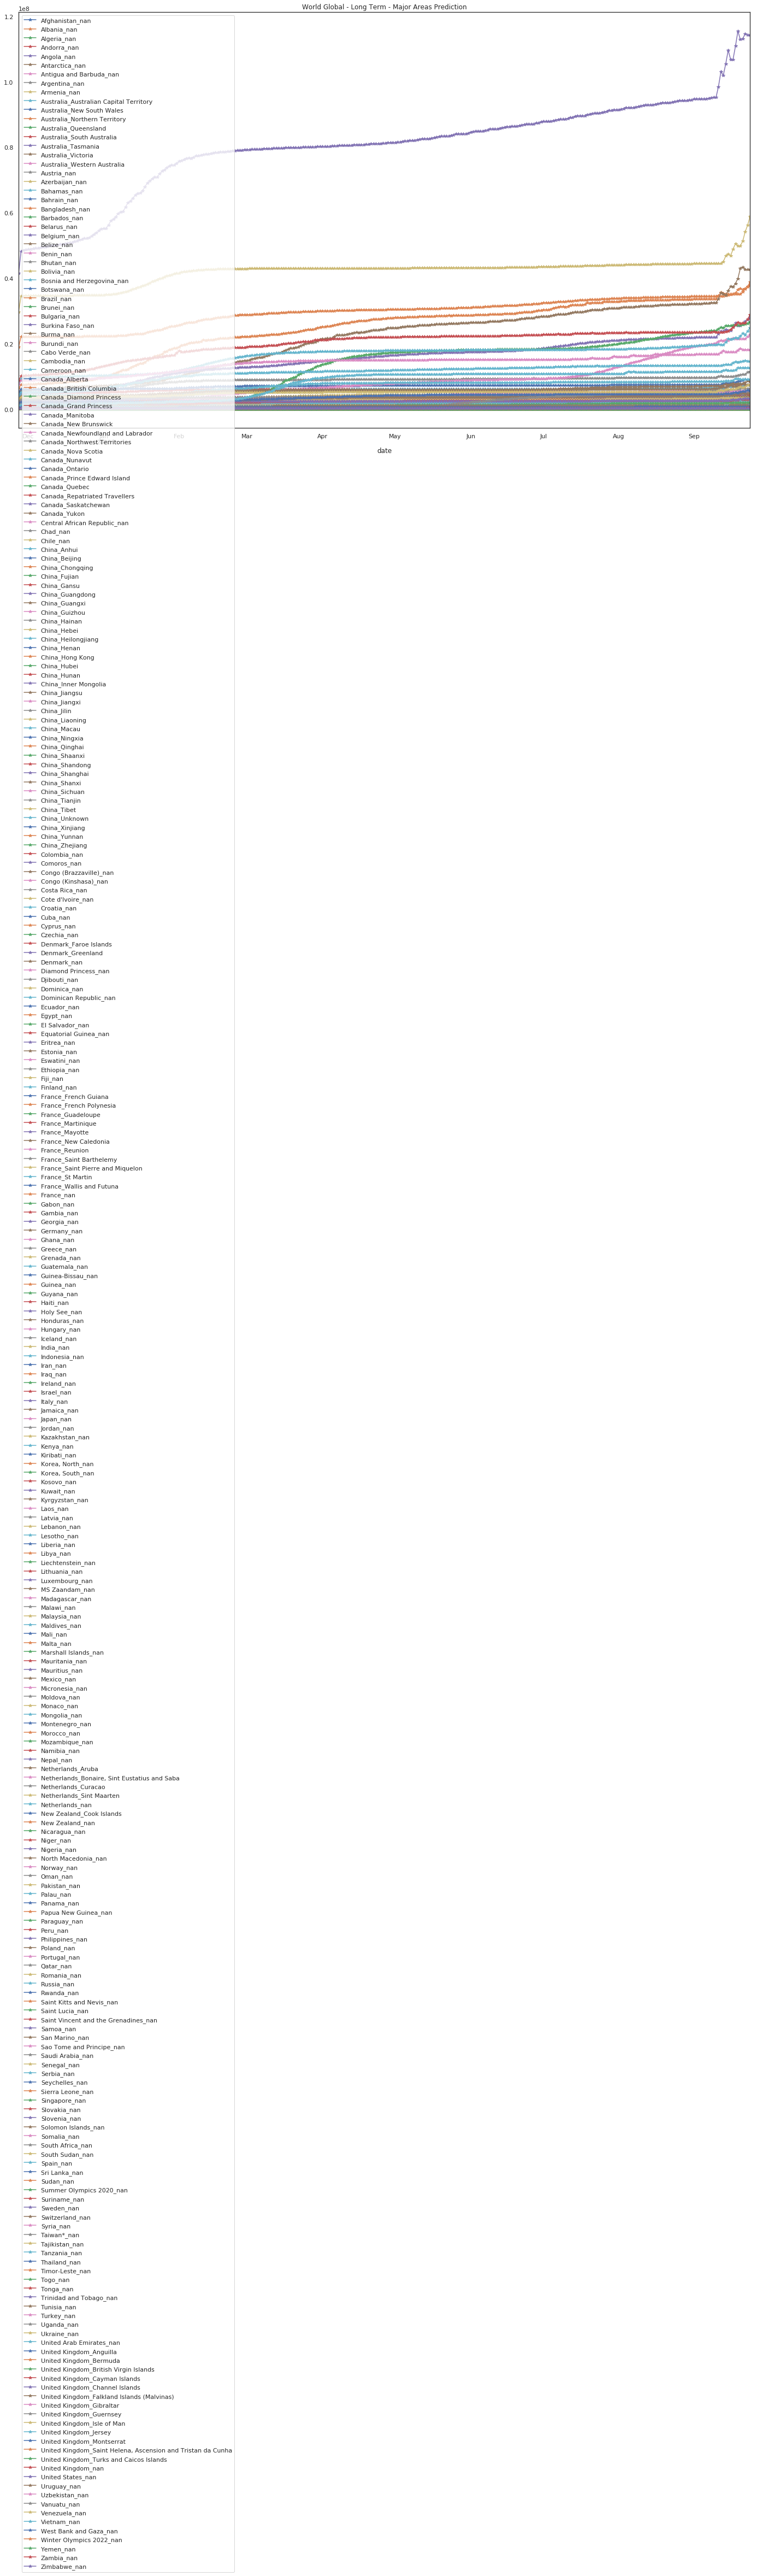

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2022-01-11         160462.0     223547.0     224964.0      27983.0   
2022-01-12         160489.0     225461.0     225561.0      28542.0   
2022-01-13         160582.0     227274.0     226140.0      28899.0   
2022-01-14         160612.0     229429.0     226728.0      29982.0   
2022-01-15         160664.0     231565.0     227242.0      29888.0   
2022-01-16         160701.0     233218.0     227799.0      30058.0   
2022-01-17         160799.0     234508.0     228464.0      30058.0   
2022-01-18         160919.0     237028.0     229246.0      29888.0   
2022-01-19         161013.0     239689.0     230521.0      29888.0   
2022-01-20         161241.0     242106.0     232022.0      31701.0   
2022-01-21         161415.0     244760.0     233807.0      32201.0   
2022-01-22         161473.0     247032.0     235931.0      33025.0   
2022-01-23         161614.0     248749.0     238011.0      33656.0   
2022-01-24         161809.0     248951.0     240151.0      33025.0   
2022-01-25         162102.0     249538.0     242560.0      34030.0   
2022-01-26         162503.0     251609.0     244698.0      34701.0   
2022-01-27         162808.0     253360.0     246788.0      35028.0   
2022-01-28         162935.0     254978.0     248666.0      35506.0   
2022-01-29         163209.0     255290.0     250403.0      35556.0   
2022-01-30         163872.0     256655.0     251922.0      35556.0   
2022-01-31         164509.0     259383.0     253294.0      35556.0   
2022-02-01         165177.0     259729.0     254721.0      35958.0   
2022-02-02         165869.0     261904.0     256154.0      35958.0   
2022-02-03         166400.0     262472.0     257210.0      36315.0   
2022-02-04         167018.0     263953.0     258213.0      36470.0   
2022-02-05         167355.0     264402.0     259074.0      36599.0   
2022-02-06         167869.0     265427.0     259543.0      36599.0   
2022-02-07         168550.0     266011.0     260049.0      36599.0   
2022-02-08         169299.0     266779.0     260689.0      36808.0   
2022-02-09         170105.0     267518.0     261328.0      36808.0   
...                     ...          ...          ...          ...   
2022-08-26         193844.0     329143.0     272102.0      46027.0   
2022-08-27         193901.0     329538.0     272136.0      46027.0   
2022-08-28         194322.0     329776.0     272157.0      46027.0   
2022-08-29         194695.0     329836.0     272196.0      46027.0   
2022-08-30         194866.0     330192.0     272239.0      46027.0   
2022-08-31         195145.0     330630.0     272274.0      46027.0   
2022-09-01         195388.0     330890.0     272328.0      46027.0   
2022-09-02         195424.0     331135.0     272377.0      46027.0   
2022-09-03         195789.0     331341.0     272401.0      46027.0   
2022-09-04         195995.0     331479.0     272417.0      46027.0   
2022-09-05         196227.0     331511.0     272434.0      46027.0   
2022-09-06         196505.0     331546.0     272450.0      46027.0   
2022-09-07         196861.0     331782.0     272464.0      46027.0   
2022-09-08         197143.0     332003.0     272482.0      46113.0   
2022-09-09         197349.0     332155.0     272500.0      46113.0   
2022-09-10         197511.0     332272.0     272512.0      46113.0   
2022-09-11         197540.0     332281.0     278014.0      46113.0   
2022-09-12         198445.0     332265.0     283363.0      46727.0   
2022-09-13         198458.0     333036.0     283771.0      48420.0   
2022-09-14         200145.0     333305.0     283257.0      48420.0   
2022-09-15         200192.0     333141.0     283099.0      48420.0   
2022-09-16         200372.0     333324.0     282991.0      48420.0   
2022-09-17         202666.0     338519.0     292719.0      48420.0   
2022-09-18         202656.0     340267.0     299798.0      48606.0   
2022-09-19

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
261                                        Tunisia_nan  33.886917    9.537499   
262                                         Turkey_nan  38.963700   35.243300   
263                                  United States_nan  40.000000 -100.000000   
264                                         Uganda_nan   1.373333   32.290275   
265                                        Ukraine_nan  48.379400   31.165600   
266                           United Arab Emirates_nan  23.424076   53.847818   
267                            United Kingdom_Anguilla  18.220600  -63.068600   
268                             United Kingdom_Bermuda  32.307800  -64.750500   
269              United Kingdom_British Virgin Islands  18.420700  -64.640000   
270                      United Kingdom_Cayman Islands  19.313300  -81.254600   
271                     United Kingdom_Channel Islands  49.372300   -2.364400   
272         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
273                           United Kingdom_Gibraltar  36.140800   -5.353600   
274                            United Kingdom_Guernsey  49.448196   -2.589490   
275                         United Kingdom_Isle of Man  54.236100   -4.548100   
276                              United Kingdom_Jersey  49.213800   -2.135800   
277                          United Kingdom_Montserrat  16.742498  -62.187366   
278  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       7              Argentina_nan -38.416100  -63.616700   
1      10  Australia_New South Wales -33.868800  151.209300   
2      15         Australia_Victoria -37.813600  144.963100   
3      17                Austria_nan  47.516200   14.550100   
4      21             Bangladesh_nan  23.685000   90.356300   
5      24                Belgium_nan  50.833300    4.469936   
6      31                 Brazil_nan -14.235000  -51.925300   
7      60                  Chile_nan -35.675100  -71.543000   
8      73            China_Hong Kong  22.300000  114.200000   
9      95               Colombia_nan   4.570900  -74.297300   
10    104                Czechia_nan  49.817500   15.473000   
11    107                Denmark_nan  56.263900    9.501800   
12    133                 France_nan  46.227600    2.213700   
13    136                Georgia_nan  42.315400   43.356900   
14    137                Georgia_nan  42.315400   43.356900   
15    138                Germany_nan  51.165691   10.451526   
16    140                 Greece_nan  39.074200   21.824300   
17    150                Hungary_nan  47.162500   19.503300   
18    152                  India_nan  20.593684   78.962880   
19    153              Indonesia_nan  -0.789300  113.921300   
20    154                   Iran_nan  32.427908   53.688046   
21    155                   Iraq_nan  33.223191   43.679291   
22    157                 Israel_nan  31.046051   34.851612   
23    158                 Israel_nan  31.046051   34.851612   
24    159                  Italy_nan  41.871940   12.567380   
25    161                  Japan_nan  36.204824  138.252924   
26    162                 Jordan_nan  31.240000   36.510000   
27    167           Korea, South_nan  35.907757  127.766922   
28    184               Malaysia_nan   4.210484  101.975766   
29    191                 Mexico_nan  23.634500 -102.552800   
30    205            Netherlands_nan  52.132600    5.291300   
31    214               Pakistan_nan  30.375300   69.345100   
32    219                   Peru_nan  -9.190000  -75.015200   
33    220            Philippines_nan  12.879721  121.774017   
34    221                 Poland_nan  51.919400   19.145100   
35    222               Portugal_nan  39.399900   -8.224500   
36    224                Romania_nan  45.943200   24.966800   
37    225                 Russia_nan  61.524010  105.318756   
38    235                 Serbia_nan  44.016500   21.005900   
39    238              Singapore_nan   1.283300  103.833300   
40    239               Slovakia_nan  48.669000   19.699000   
41    243           South Africa_nan -30.559500   22.937500   
42    245                  Spain_nan  40.463667   -3.749220   
43    250                 Sweden_nan  60.128161   18.643501   
44    251            Switzerland_nan  46.818200    8.227500   
45    253                Taiwan*_nan  23.700000  121.000000   
46    256               Thailand_nan  15.870032  100.992541   
47    262                 Turkey_nan  38.963700   35.243300   
48    263          United States_nan  40.000000 -100.000000   
49    265                Ukraine_nan  48.379400   31.165600   
50    280         United Kingdom_nan  55.378100   -3.436000   
51    285                Vietnam_nan  14.058324  108.277199   

    2021-11-27 00:00:00  2021-11-28 00:00:00  2021-11-29 00:00:00  \
0             4696948.0            5325560.0            5326448.0   
1              209514.0             209638.0              81499.0   
2              242424.0             243279.0             120814.0   
3             1096784.0            1118256.0            1133813.0   
4             1488113.0            1575579.0            1575784.0   
5             1595976.0            1701633.0            1731443.0   
6            19035187.0           22081833.0           22085369.0   
7             1643419.0            1757077.0            1759405.0   
8              150531.0             150533.

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()